In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from scipy.sparse import csr_matrix, diags
from scipy.sparse.linalg import norm, svds

from torch.utils.data import Dataset
import torch
import torch.nn as nn
import torch.optim as optim

from polara.lib.tensor import hooi
from polara.lib.sparse import tensor_outer_at

from dataprep import full_preproccessing
from utils import *
# from RecVAE.utils import *
# from RecVAE.model import VAE as RecVAE

In [2]:
def fix_torch_seed(seed, conv_determinism=True):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # settings below may affect computational performance
    # see https://pytorch.org/docs/stable/notes/randomness.html:
    if conv_determinism:
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

def set_random_seed(seed):
#     torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    
# fix_torch_seed(42)
set_random_seed(42)

In [3]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
device

device(type='cuda', index=0)

# Data preprocessing

In [4]:
data = pd.read_csv('Amazon_Video_Games.csv')
data.rename(columns = {'reviewerID' : 'userid', 'asin' : 'movieid', "overall" : "rating", "unixReviewTime" : "timestamp"}, inplace = True)

In [5]:
training, testset_valid, holdout_valid, testset, holdout, data_description, data_index = full_preproccessing(data)

There are 24303 users
Filtered 17693 invalid observations.


In [6]:
check = pd.concat((training, testset_valid, holdout_valid, testset, holdout))

In [9]:
check.shape[0] / check.userid.nunique() / check.movieid.nunique() * 100

0.10033970223792682

In [7]:
check.shape[0]

160585

In [8]:
check.userid.nunique(), check.movieid.nunique()

(16156, 9906)

In [20]:
del data

# Baselines

## TopPop

In [21]:
def build_popularity_model(trainset, trainset_description):
    itemid = trainset_description['items']
    item_popularity = trainset[itemid].value_counts()
    return item_popularity

def popularity_model_scoring(params, testset, testset_description):
    item_popularity = params
    n_items = item_popularity.index.max() + 1
    n_users = testset_description['n_test_users']
    # fill in popularity scores for each item with indices from 0 to n_items-1
    popularity_scores = np.zeros(n_items,)
    popularity_scores[item_popularity.index] = item_popularity.values
    # same scores for each test user
    scores = np.tile(popularity_scores, n_users).reshape(n_users, n_items)
    return scores

## Normalized PureSVD

In [16]:
def matrix_from_observations(data, data_description):
    useridx = data[data_description['users']]
    itemidx = data[data_description['items']]
    values = data[data_description['feedback']]
    return csr_matrix((values, (useridx, itemidx)), shape=(useridx.values.max() + 1, data_description["n_items"]), dtype='f8')

def build_svd_model(config, data, data_description):
    source_matrix = matrix_from_observations(data, data_description)
    #print(source_matrix.shape)
    D = norm(source_matrix, axis=0)
    A = source_matrix.dot(diags(D**(config['f']-1)))
    _, _, vt = svds(A, k=config['rank'], return_singular_vectors='vh')
#     singular_values = s[::-1]
    item_factors = np.ascontiguousarray(vt[::-1, :].T)
    return item_factors

def svd_model_scoring(params, data, data_description):
    item_factors = params
    test_data = data.assign(
        userid = pd.factorize(data['userid'])[0]
    )
    test_matrix = matrix_from_observations(test_data, data_description)
    #print(test_matrix.shape, item_factors.shape)
    scores = test_matrix.dot(item_factors) @ item_factors.T
    return scores

## EASEr

In [32]:
def matrix_from_observations(data, data_description):
    useridx = data[data_description['users']]
    itemidx = data[data_description['items']]
    values = data[data_description['feedback']]
    return csr_matrix((values, (useridx, itemidx)), shape=(useridx.values.max() + 1, data_description["n_items"]), dtype='f8')

def easer(data, data_description, lmbda=500):
    X = matrix_from_observations(data, data_description)
    G = X.T.dot(X)
    diag_indices = np.diag_indices(G.shape[0])
    G[diag_indices] += lmbda
    P = np.linalg.inv(G.A)
    B = P / (-np.diag(P))
    B[diag_indices] = 0
    
    return B

def easer_scoring(params, data, data_description):
    item_factors = params
    test_data = data.assign(
        userid = pd.factorize(data['userid'])[0]
    )
    test_matrix = matrix_from_observations(test_data, data_description)
    scores = test_matrix.dot(item_factors)
    return scores

## CoFFee

In [8]:
def tf_model_build(config, data, data_description):
    userid = data_description["users"]
    itemid = data_description["items"]
    feedback = data_description["feedback"]

    idx = data[[userid, itemid, feedback]].values
    idx[:, -1] = idx[:, -1] - data_description['min_rating'] # works only for integer ratings!
    val = np.ones(idx.shape[0], dtype='f8')
    
    n_users = data_description["n_users"]
    n_items = data_description["n_items"]
    n_ratings = data_description["n_ratings"]
    shape = (n_users, n_items, n_ratings)
    core_shape = config['mlrank']
    num_iters = config["num_iters"]
    
    u0, u1, u2, g = hooi(
        idx, val, shape, core_shape,
        num_iters=num_iters,
        parallel_ttm=False, growth_tol=0.01,
    )
    return u0, u1, u2
        

def tf_scoring(params, data, data_description):
    user_factors, item_factors, feedback_factors = params
    userid = data_description["users"]
    itemid = data_description["items"]
    feedback = data_description["feedback"]

    data = data.sort_values(userid)
    useridx = data[userid].values
    itemidx = data[itemid].values
    ratings = data[feedback].values
    ratings = ratings - data_description['min_rating'] # works only for integer ratings!
    
    tensor_outer = tensor_outer_at('cpu')
    # use the fact that test data is sorted by users for reduction:
    scores = tensor_outer(
        1.0,
        item_factors,
        feedback_factors,
        itemidx,
        ratings
    )
    scores = np.add.reduceat(scores, np.r_[0, np.where(np.diff(useridx))[0]+1])
    scores = np.tensordot(
        scores,
        feedback_factors[-1, :],
        axes=(2, 0)
    ).dot(item_factors.T)
    return scores

## Simple AE

In [8]:
class MVDataset(Dataset):
    def __init__(self, data, data_description, augment=False):
        self.augment = augment
        
        useridx = data[data_description['users']].values
        itemidx = data[data_description['items']].values
        values = np.ones(len(itemidx), dtype=np.float32)
        self.matrix = torch.sparse_coo_tensor(np.array([useridx, itemidx]), torch.tensor(values),
                                      size=torch.Size((data_description["n_users"], data_description["n_items"])), dtype=torch.float32)

    def __len__(self):
        return self.matrix.shape[0]

    def __getitem__(self, idx):
        if self.augment:
            num_noise = np.random.randint(0, int(0.1 * self.matrix.shape[1]))
            idxs = torch.randint(0, self.matrix.shape[1], size=(num_noise,))
            noised_input = self.matrix[idx].detach().clone().to_dense()
            noised_input[idxs] = torch.distributions.bernoulli.Bernoulli(0.5).sample(sample_shape=(num_noise,)).to(self.matrix.device)
            
            useridx = np.zeros_like(noised_input.cpu())
            itemidx = np.arange(self.matrix.shape[1])
            noised_input = torch.sparse_coo_tensor(np.array([itemidx,]), noised_input,
                                                   size=torch.Size((data_description["n_items"],)), dtype=torch.float32)
            return noised_input, self.matrix[idx]
        else:
            return self.matrix[idx], self.matrix[idx]

In [17]:
class baseAE(nn.Module):
    def __init__(self, n_items, hid):
        super(baseAE, self).__init__()
        self.V = nn.Linear(n_items, hid)
        torch.nn.init.xavier_uniform_(self.V.weight)
        self.VT = nn.Linear(hid, n_items)
        torch.nn.init.xavier_uniform_(self.VT.weight)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # encode
        x = self.V(x)
        x = self.relu(x)
        # decode
        output = self.VT(x)
        output = self.sigmoid(output)
        return output

In [18]:
def base_model(h, data_description, device):
    ae = baseAE(data_description['n_items'], h).to(device)
    criterion = nn.BCEWithLogitsLoss().to(device)
    optimizer = optim.Adam(ae.parameters())
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    
    return ae, criterion, optimizer, scheduler

## RecVAE

In [7]:
vae = RecVAE(600, 200, 1000)
sum(p.numel() for p in vae.parameters() if p.requires_grad)

2490400

# Tuning

## Normalized PureSVD

In [14]:
rank_grid = []
for i in range(5, 10):
    rank_grid.append(2 * 2 ** i)
    rank_grid.append(3 * 2 ** i)
    
rank_grid = np.array(rank_grid)

f_grid = np.linspace(0, 2, 21)

In [ ]:
hr_tf = {}
mrr_tf = {}
c_tf = {}
grid = list(zip(np.meshgrid(rank_grid, f_grid)[0].flatten(), np.meshgrid(rank_grid, f_grid)[1].flatten()))
for params in tqdm(grid):
    r, f = params
    svd_config = {'rank': int(r), 'f': f}
    svd_params = build_svd_model(svd_config, training, data_description)
    svd_scores = svd_model_scoring(svd_params, testset_valid, data_description)
    downvote_seen_items(svd_scores, testset_valid, data_description)
    svd_recs = topn_recommendations(svd_scores, topn=10)
    for alpha in [2,3,4,5]:
        hr, hr_pos, hr_neg, mrr, mrr_pos, mrr_neg, cov, C = model_evaluate(svd_recs, holdout_valid, data_description, alpha=alpha)
        hr_tf[f'r={r}, f={f:.2f}, alpha={alpha}'] = hr
        mrr_tf[f'r={r}, f={f:.2f}, alpha={alpha}'] = mrr
        c_tf[f'r={r}, f={f:.2f}, alpha={alpha}'] = C

In [ ]:
sorted(c_tf.items(), key=lambda x: x[1], reverse=True)

## EASEr

In [9]:
lambda_grid = np.arange(10, 510, 10)

In [10]:
hr_tf = {}
mrr_tf = {}
c_tf = {}
for lmbda in tqdm(lambda_grid):
    easer_params = easer(training, data_description, lmbda=lmbda)
    easer_scores = easer_scoring(easer_params, testset_valid, data_description)
    downvote_seen_items(easer_scores, testset_valid, data_description)
    easer_recs = topn_recommendations(easer_scores, topn=10)
    for alpha in [2,3,4,5]:
        hr, hr_pos, hr_neg, mrr, mrr_pos, mrr_neg, cov, C = model_evaluate(easer_recs, holdout_valid, data_description, alpha=alpha)
        hr_tf[f'lambda={lmbda}, alpha={alpha}'] = hr
        mrr_tf[f'lambda={lmbda}, alpha={alpha}'] = mrr
        c_tf[f'lambda={lmbda}, alpha={alpha}'] = C

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
sorted(c_tf.items(), key=lambda x: x[1], reverse=True)

## CoFFee

In [13]:
config = {
    "scaling": 1,
    "n_ratings": data_description['n_ratings'],
    "num_iters": 4,
    "params": None,
    "randomized": True,
    "growth_tol": 1e-4,
    "seed": 42
}

grid1 = 2**np.arange(4, 12)
grid2 = np.arange(2, 5)
grid = np.meshgrid(grid1, grid2)

In [12]:
hr_tf = {}
mrr_tf = {}
for r12, r3 in tqdm(zip(grid[0].flatten(), grid[1].flatten()), total=24):
    config['mlrank'] = (r12, r12, r3)
    tf_params = tf_model_build(config, training, data_description)
    tf_scores = tf_scoring(tf_params, testset_valid, data_description)
    downvote_seen_items(tf_scores, testset_valid, data_description)
    tf_recs = topn_recommendations(tf_scores, topn=10)
    hr, hr_pos, hr_neg, mrr, mrr_pos, mrr_neg, cov, C = model_evaluate(tf_recs, holdout_valid, data_description)
    hr_tf[(r12, r3)] = hr
    mrr_tf[(r12, r3)] = mrr

  0%|          | 0/24 [00:00<?, ?it/s]

growth of the core: 1.0
growth of the core: 0.17108376145578136
growth of the core: 0.013724276626127477
growth of the core: 0.002121752668025982
Done
growth of the core: 1.0
growth of the core: 0.1944648491989059
growth of the core: 0.02467704747273349
growth of the core: 0.005981755700370528
Done
growth of the core: 1.0
growth of the core: 0.16282144181882102
growth of the core: 0.029912952116613767
growth of the core: 0.013916498704220537
Done
growth of the core: 1.0
growth of the core: 0.23035313236669488
growth of the core: 0.034784826568450604
growth of the core: 0.011006067169166954
Done
growth of the core: 1.0
growth of the core: 0.17594728189169354
growth of the core: 0.030919135038606764
growth of the core: 0.008959802437981649
Done
growth of the core: 1.0
growth of the core: 0.1619910003475919
growth of the core: 0.025820893734533307
growth of the core: 0.008684790230411127
Done
growth of the core: 1.0
growth of the core: 0.19297251628357556
growth of the core: 0.01668695007

In [13]:
hr_tf

{(16, 2): 0.05102639296187683,
 (32, 2): 0.05689149560117302,
 (64, 2): 0.06099706744868035,
 (128, 2): 0.05337243401759531,
 (256, 2): 0.06862170087976541,
 (512, 2): 0.031085043988269796,
 (1024, 2): 0.021114369501466276,
 (2048, 2): 0.008211143695014663,
 (16, 3): 0.04868035190615835,
 (32, 3): 0.04574780058651026,
 (64, 3): 0.052785923753665684,
 (128, 3): 0.047507331378299114,
 (256, 3): 0.04105571847507332,
 (512, 3): 0.03284457478005865,
 (1024, 3): 0.01818181818181818,
 (2048, 3): 0.004105571847507331,
 (16, 4): 0.04281524926686217,
 (32, 4): 0.04574780058651026,
 (64, 4): 0.04926686217008798,
 (128, 4): 0.0469208211143695,
 (256, 4): 0.0404692082111437,
 (512, 4): 0.03167155425219941,
 (1024, 4): 0.01935483870967742,
 (2048, 4): 0.004105571847507331}

## Simple AE

In [19]:
grid = 2**np.arange(4, 11)

  0%|          | 0/7 [00:00<?, ?it/s]

Hidden sizes: 16


C:\Users\Liza\Desktop\Thesis\utils.py:68: RuntimeWarning: invalid value encountered in double_scalars
  C = (TP/N - S*P) / np.sqrt(P*S*(1-P)*(1-S))
C:\Users\Liza\Desktop\Thesis\utils.py:68: RuntimeWarning: invalid value encountered in double_scalars
  C = (TP/N - S*P) / np.sqrt(P*S*(1-P)*(1-S))
C:\Users\Liza\Desktop\Thesis\utils.py:68: RuntimeWarning: invalid value encountered in double_scalars
  C = (TP/N - S*P) / np.sqrt(P*S*(1-P)*(1-S))
C:\Users\Liza\Desktop\Thesis\utils.py:68: RuntimeWarning: invalid value encountered in double_scalars
  C = (TP/N - S*P) / np.sqrt(P*S*(1-P)*(1-S))
C:\Users\Liza\Desktop\Thesis\utils.py:68: RuntimeWarning: invalid value encountered in double_scalars
  C = (TP/N - S*P) / np.sqrt(P*S*(1-P)*(1-S))
C:\Users\Liza\Desktop\Thesis\utils.py:68: RuntimeWarning: invalid value encountered in double_scalars
  C = (TP/N - S*P) / np.sqrt(P*S*(1-P)*(1-S))
C:\Users\Liza\Desktop\Thesis\utils.py:68: RuntimeWarning: invalid value encountered in double_scalars
  C = (TP/

Current epoch 76
Results for alpha=2


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.002253,0.000726,0.004341,0.001101,0.002253,0.0,0.000726,0.0,0.001101,0.0,0.009956


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.005006,0.001128,0.007571,0.002026,0.005006,0.0,0.001128,0.0,0.002026,0.0,0.014862


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.00801,0.001326,0.015041,0.002772,0.00776,0.00025,0.001307,0.000019,0.002707,0.000066,0.004836


Results for alpha=3


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.002253,0.000726,0.004341,0.001101,0.002253,0.0,0.000726,0.0,0.001101,0.0,0.014586


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.005006,0.001128,0.007571,0.002026,0.005006,0.0,0.001128,0.0,0.002026,0.0,0.021773


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.00801,0.001326,0.015041,0.002772,0.00776,0.00025,0.001307,0.000019,0.002707,0.000066,0.017572


Results for alpha=4


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.004255,0.00136,0.004139,0.00207,0.003755,0.000501,0.001227,0.000134,0.001848,0.000222,0.011948


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.00776,0.001836,0.007369,0.003211,0.007259,0.000501,0.001702,0.000134,0.002989,0.000222,0.028158


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.008761,0.001916,0.013931,0.003477,0.00801,0.000751,0.00176,0.000156,0.003185,0.000292,0.024847


Results for alpha=5


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.001001,0.000288,0.005148,0.000459,0.001001,0.0,0.000288,0.0,0.000459,0.0,0.025527


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.003254,0.000596,0.007975,0.001196,0.002753,0.000501,0.000533,0.000064,0.001037,0.000159,0.028081


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.006008,0.000785,0.014537,0.001889,0.004255,0.001752,0.000639,0.000146,0.001419,0.00047,0.01628


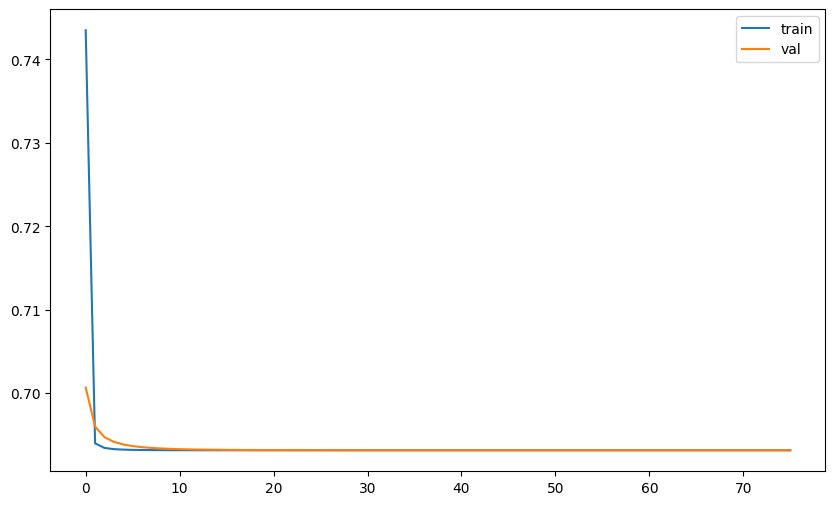

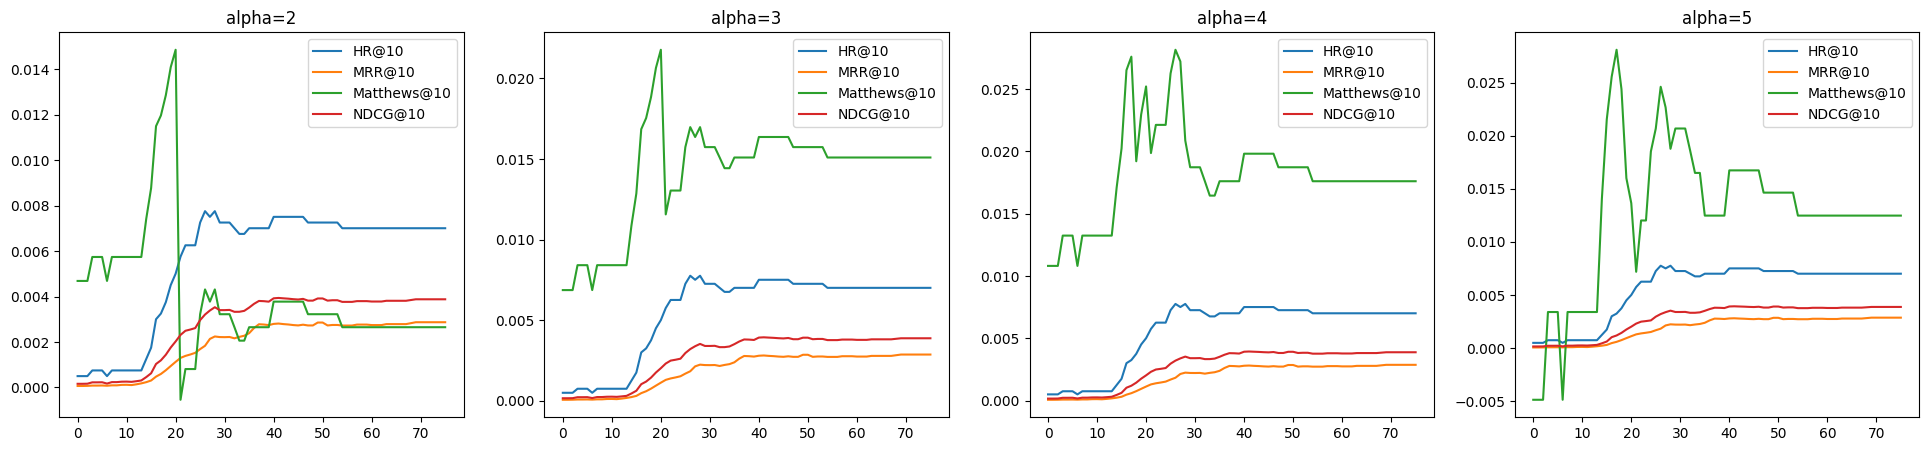

Test loss: 0.6931525468826294
Train loss: 0.6931472882030946


Hidden sizes: 32
Current epoch 94
Results for alpha=2


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.001752,0.000697,0.004341,0.000956,0.001752,0.0,0.000697,0.0,0.000956,0.0,0.008778


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.005757,0.001197,0.007672,0.002216,0.005757,0.0,0.001197,0.0,0.002216,0.0,0.015944


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.008511,0.001369,0.016354,0.002889,0.008511,0.0,0.001369,0.0,0.002889,0.0,0.019412


Results for alpha=3


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.001752,0.000697,0.004341,0.000956,0.001752,0.0,0.000697,0.0,0.000956,0.0,0.01286


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.005757,0.001197,0.007672,0.002216,0.005757,0.0,0.001197,0.0,0.002216,0.0,0.023358


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.008511,0.001369,0.016354,0.002889,0.00826,0.00025,0.001355,0.000014,0.00283,0.000059,0.018725


Results for alpha=4


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.001752,0.000697,0.004341,0.000956,0.001752,0.0,0.000697,0.0,0.000956,0.0,0.020241


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.005757,0.001197,0.007672,0.002216,0.005757,0.0,0.001197,0.0,0.002216,0.0,0.036763


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.008511,0.001369,0.016354,0.002889,0.00801,0.000501,0.001339,0.00003,0.002769,0.00012,0.030847


Results for alpha=5


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.002253,0.000809,0.004139,0.00116,0.001752,0.000501,0.000676,0.000134,0.000938,0.000222,0.016704


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.005507,0.001233,0.007167,0.002202,0.004506,0.001001,0.001041,0.000193,0.001826,0.000376,0.032312


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.008511,0.001433,0.015546,0.00295,0.006758,0.001752,0.001181,0.000252,0.002375,0.000575,0.035667


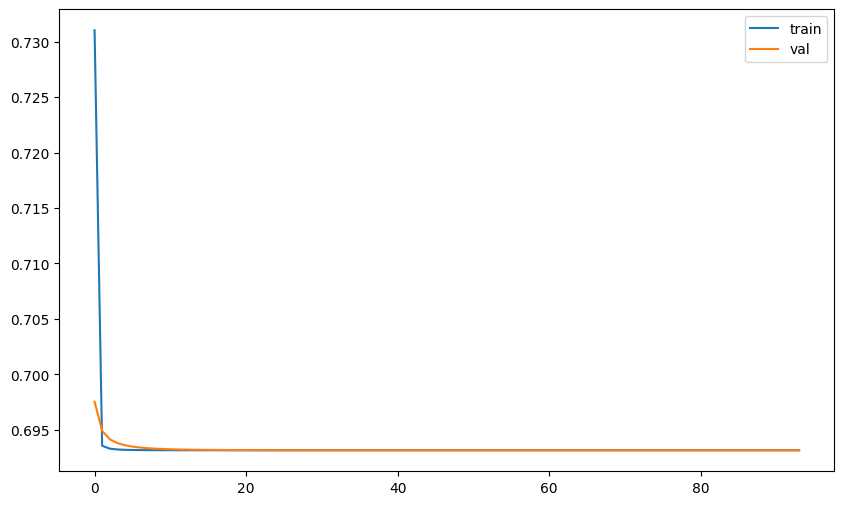

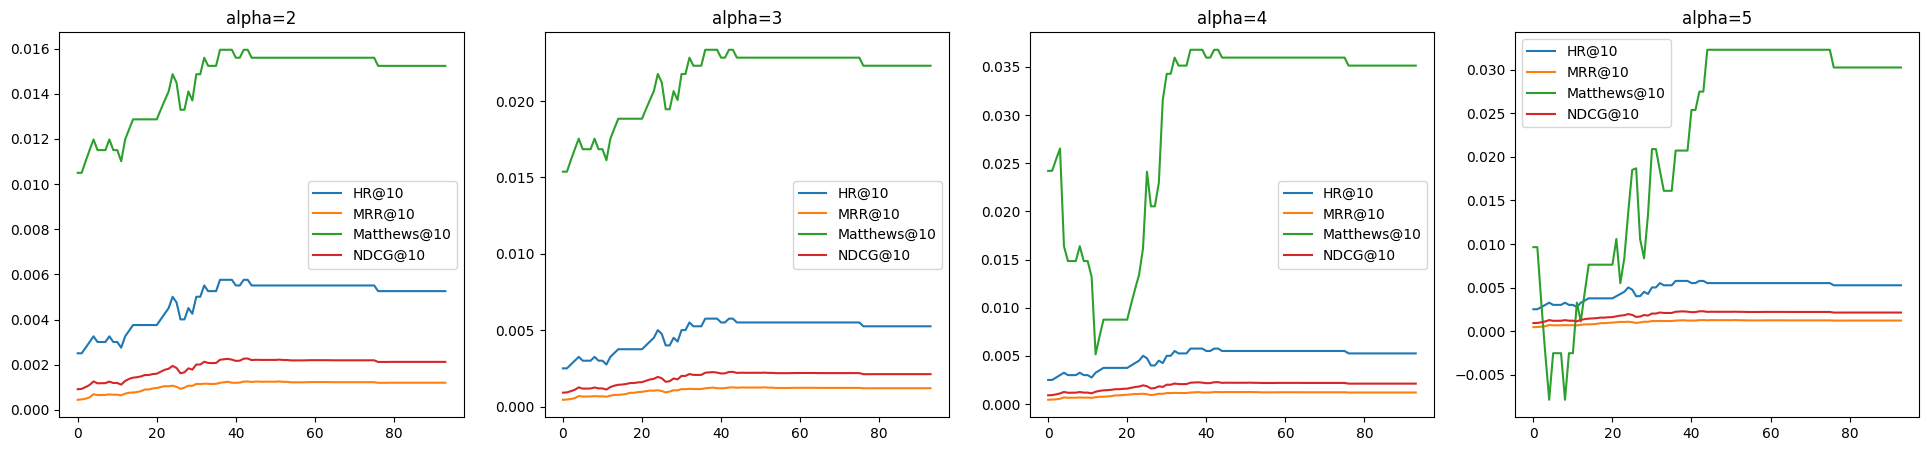

Test loss: 0.6931463479995728
Train loss: 0.6931471824645996


Hidden sizes: 64
Current epoch 102
Results for alpha=2


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.005257,0.002107,0.006158,0.002898,0.005257,0.0,0.002107,0.0,0.002898,0.0,0.015231


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.007509,0.002364,0.014335,0.003583,0.007509,0.0,0.002364,0.0,0.003583,0.0,0.018225


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.011765,0.002616,0.025035,0.004603,0.011514,0.00025,0.002601,0.000015,0.004543,0.00006,0.011294


Results for alpha=3


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.005257,0.002219,0.006158,0.002979,0.005257,0.0,0.002219,0.0,0.002979,0.0,0.022314


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.007259,0.002445,0.014436,0.003585,0.007259,0.0,0.002445,0.0,0.003585,0.0,0.026248


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.011014,0.002675,0.025439,0.004495,0.010263,0.000751,0.002623,0.000051,0.004306,0.000189,0.006743


Results for alpha=4


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.005257,0.002219,0.006158,0.002979,0.005006,0.00025,0.002136,0.000083,0.002854,0.000125,0.026282


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.007259,0.002445,0.014436,0.003585,0.007009,0.00025,0.002362,0.000083,0.00346,0.000125,0.033784


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.011014,0.002675,0.025439,0.004495,0.009762,0.001252,0.002527,0.000148,0.004123,0.000372,0.020368


Results for alpha=5


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.005006,0.002169,0.006259,0.002883,0.004005,0.001001,0.001794,0.000375,0.002349,0.000533,0.028161


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.007259,0.00244,0.014436,0.003581,0.005507,0.001752,0.001981,0.00046,0.002821,0.00076,0.026707


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.010263,0.002621,0.025944,0.004306,0.007009,0.003254,0.002075,0.000546,0.003189,0.001117,0.01603


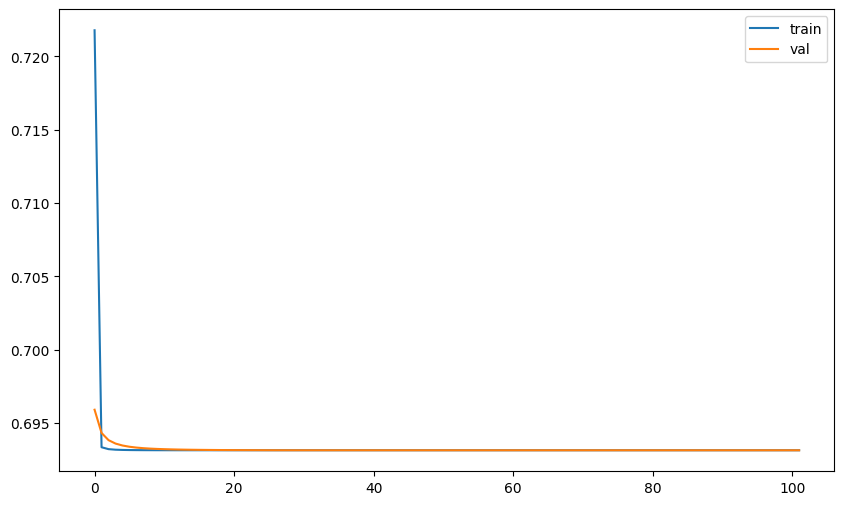

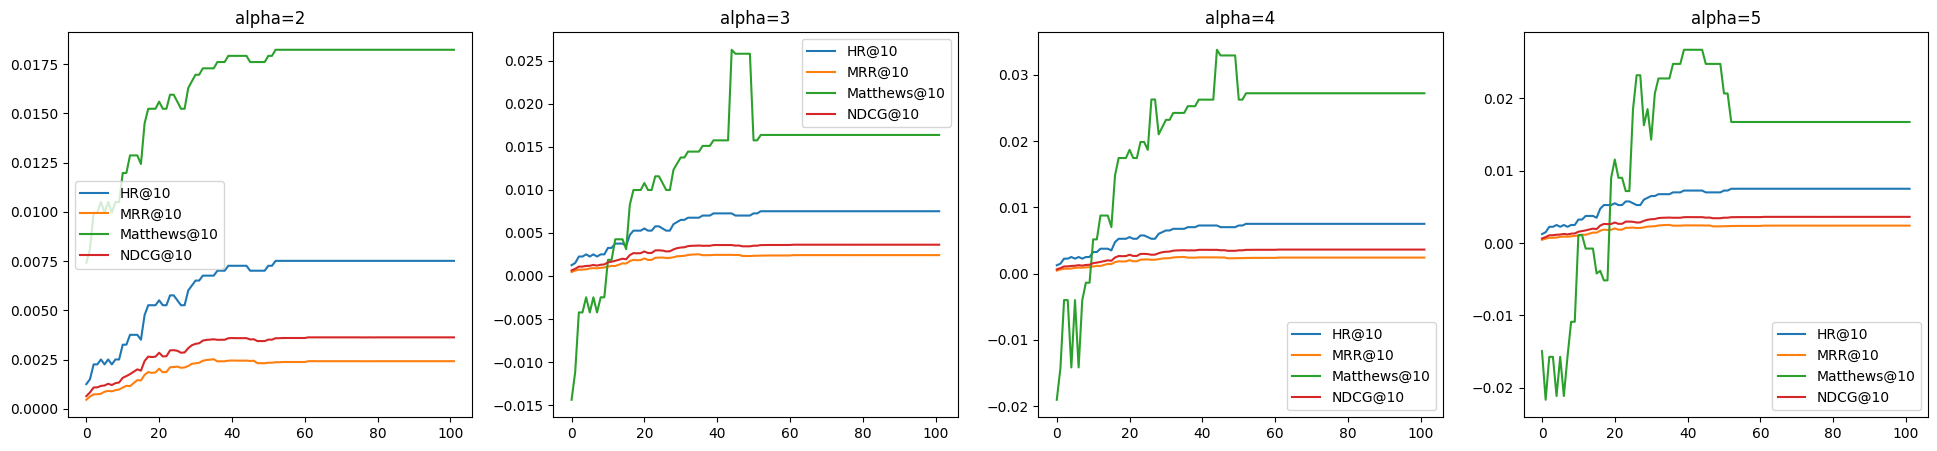

Test loss: 0.6931462287902832
Train loss: 0.6931471824645996


Hidden sizes: 128
Current epoch 71
Results for alpha=2


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.008511,0.005373,0.013325,0.006154,0.00826,0.00025,0.005123,0.00025,0.005904,0.00025,0.005835


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.011514,0.005782,0.03089,0.007134,0.011264,0.00025,0.005532,0.00025,0.006883,0.00025,0.010923


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.013267,0.0059,0.063194,0.007573,0.013016,0.00025,0.00565,0.00025,0.007322,0.00025,0.013394


Results for alpha=3


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.008511,0.005373,0.013325,0.006154,0.00826,0.00025,0.005123,0.00025,0.005904,0.00025,0.018725


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.011514,0.005782,0.03089,0.007134,0.011264,0.00025,0.005532,0.00025,0.006883,0.00025,0.024765


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.013267,0.0059,0.063194,0.007573,0.013016,0.00025,0.00565,0.00025,0.007322,0.00025,0.027793


Results for alpha=4


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.008511,0.005373,0.013325,0.006154,0.00776,0.000751,0.004873,0.000501,0.005588,0.000566,0.02389


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.011514,0.005782,0.03089,0.007134,0.010763,0.000751,0.005281,0.000501,0.006568,0.000566,0.034172


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.013267,0.0059,0.063194,0.007573,0.012265,0.001001,0.005383,0.000517,0.006944,0.000629,0.033677


Results for alpha=5


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.00826,0.005861,0.014739,0.006468,0.006008,0.002253,0.003922,0.00194,0.00445,0.002018,0.022649


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.009762,0.006052,0.034424,0.006945,0.007509,0.002253,0.004112,0.00194,0.004927,0.002018,0.033167


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.012265,0.006226,0.062285,0.007573,0.009512,0.002753,0.004249,0.001977,0.005426,0.002147,0.038656


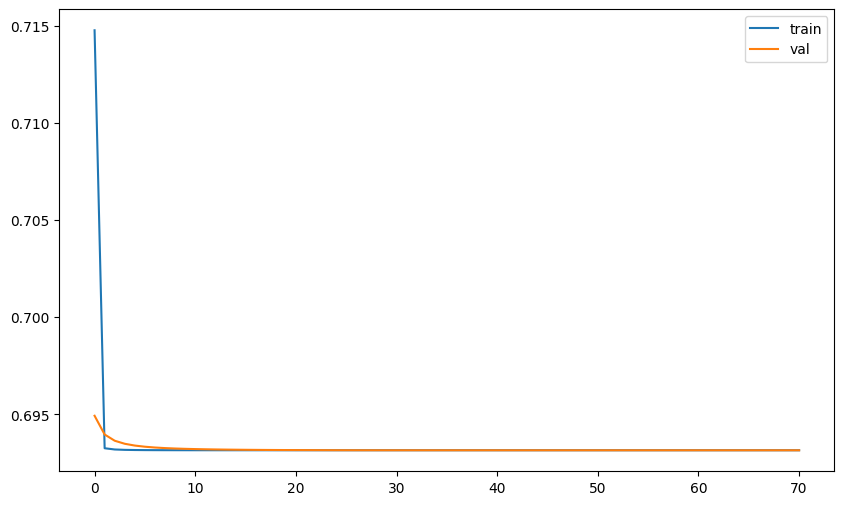

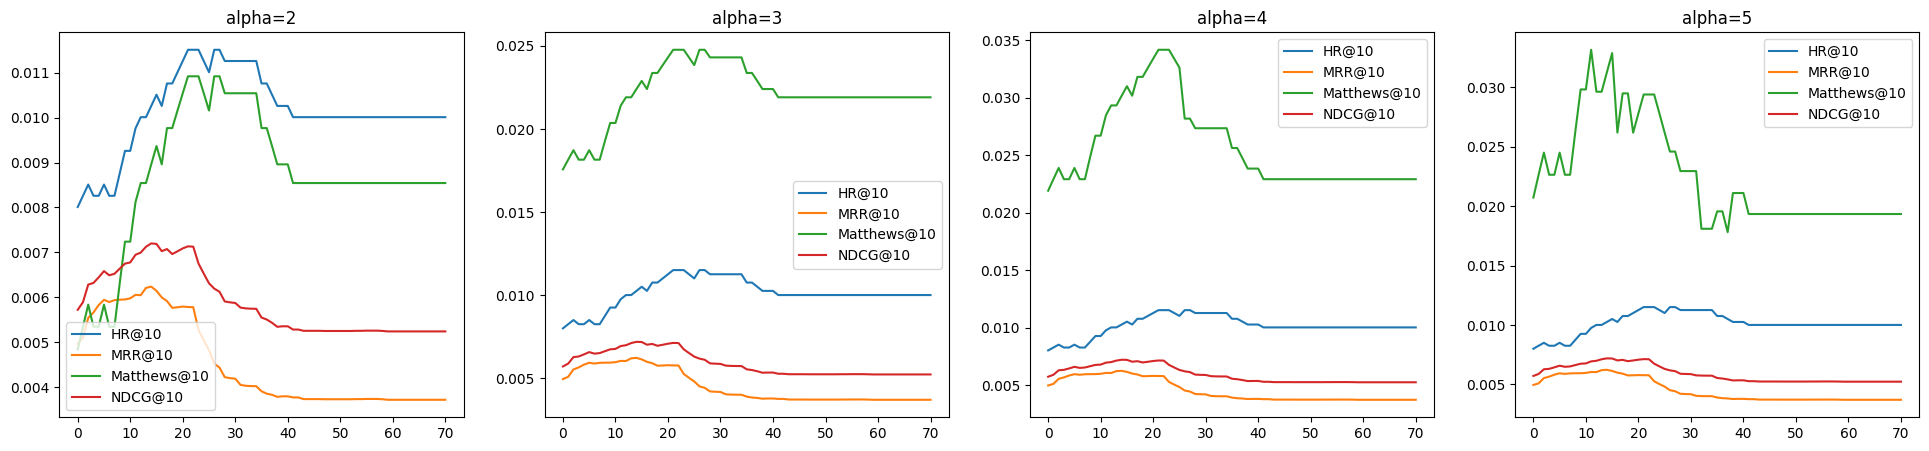

Test loss: 0.6931546926498413
Train loss: 0.6931472651723813


Hidden sizes: 256
Current epoch 69
Results for alpha=2


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.003004,0.00169,0.059863,0.002016,0.003004,0.0,0.00169,0.0,0.002016,0.0,0.0115


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.005757,0.002033,0.106501,0.002882,0.005757,0.0,0.002033,0.0,0.002882,0.0,0.015944


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.008761,0.002231,0.171815,0.003628,0.008511,0.00025,0.002218,0.000013,0.00357,0.000058,0.006315


Results for alpha=3


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.003004,0.00169,0.059863,0.002016,0.003004,0.0,0.00169,0.0,0.002016,0.0,0.016848


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.005757,0.002033,0.106501,0.002882,0.005757,0.0,0.002033,0.0,0.002882,0.0,0.023358


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.008761,0.002231,0.171815,0.003628,0.00826,0.000501,0.002197,0.000034,0.003503,0.000126,0.009707


Results for alpha=4


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.003004,0.00169,0.059863,0.002016,0.003004,0.0,0.00169,0.0,0.002016,0.0,0.026518


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.005757,0.002033,0.106501,0.002882,0.005757,0.0,0.002033,0.0,0.002882,0.0,0.036763


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.008761,0.002231,0.171815,0.003628,0.00801,0.000751,0.002182,0.00005,0.003442,0.000187,0.024847


Results for alpha=5


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.003004,0.00169,0.059863,0.002016,0.002503,0.000501,0.001377,0.000313,0.001658,0.000358,0.025536


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.005757,0.002033,0.106501,0.002882,0.005006,0.000751,0.001684,0.000349,0.00244,0.000442,0.041044


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.008761,0.002231,0.171815,0.003628,0.006758,0.002003,0.0018,0.000432,0.002875,0.000753,0.031827


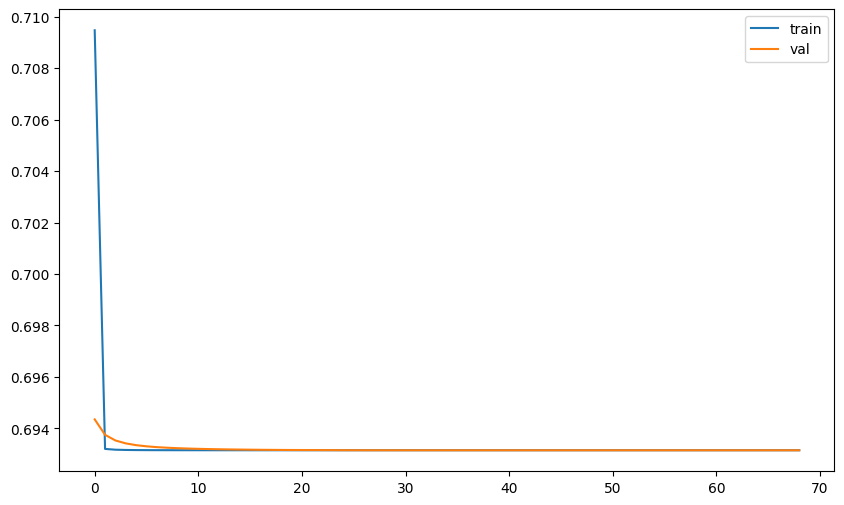

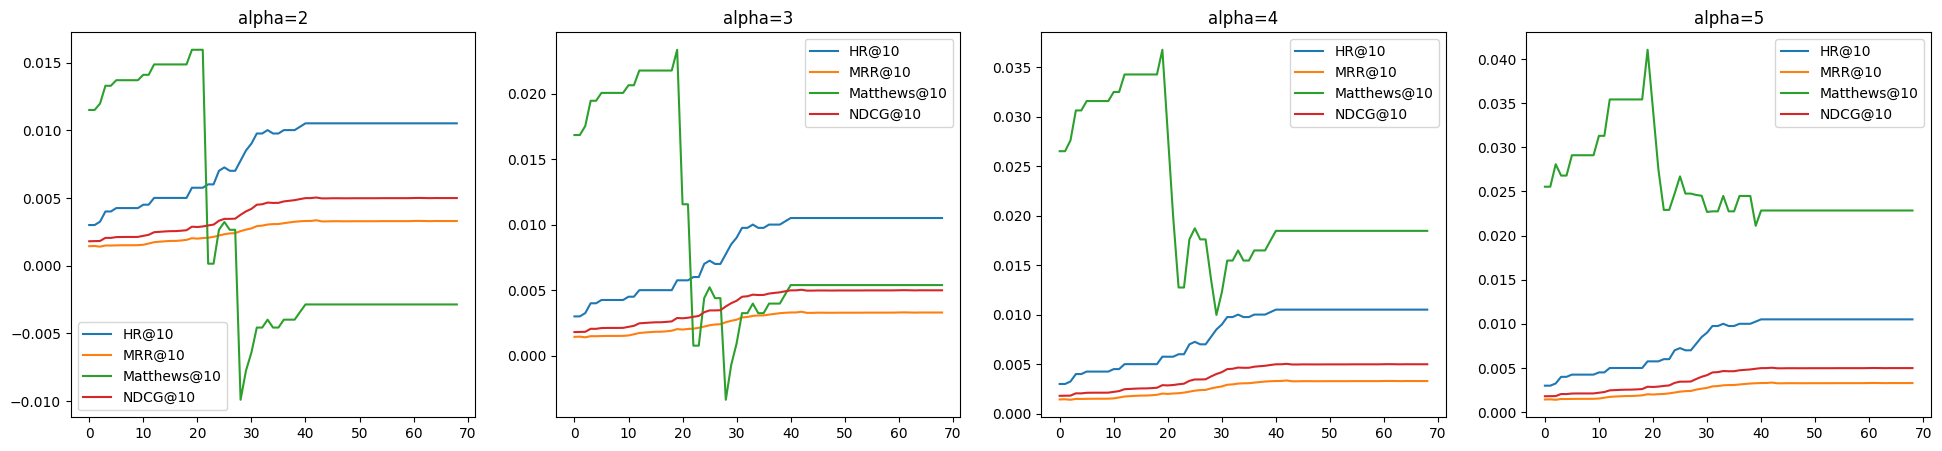

Test loss: 0.6931570172309875
Train loss: 0.6931472714732368


Hidden sizes: 512
Current epoch 71
Results for alpha=2


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.002253,0.001352,0.116293,0.001568,0.002253,0.0,0.001352,0.0,0.001568,0.0,0.009956


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.004005,0.001563,0.199172,0.002112,0.004005,0.0,0.001563,0.0,0.002112,0.0,0.013286


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.006008,0.001705,0.304563,0.002622,0.005757,0.00025,0.001684,0.000021,0.002554,0.000068,0.000149


Results for alpha=3


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.001752,0.00126,0.094589,0.001381,0.001752,0.0,0.00126,0.0,0.001381,0.0,0.01286


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.003004,0.001417,0.162023,0.001776,0.003004,0.0,0.001417,0.0,0.001776,0.0,0.016848


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.004756,0.001527,0.251464,0.002205,0.004506,0.00025,0.001515,0.000013,0.002148,0.000057,0.008249


Results for alpha=4


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.002503,0.001402,0.113366,0.001667,0.002003,0.000501,0.001268,0.000134,0.001445,0.000222,-0.001377


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.004005,0.001587,0.195639,0.002137,0.003504,0.000501,0.001453,0.000134,0.001915,0.000222,0.010399


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.006008,0.001742,0.299011,0.002663,0.005006,0.001001,0.001565,0.000177,0.002303,0.000359,0.00448


Results for alpha=5


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.002503,0.001456,0.103977,0.001711,0.001752,0.000751,0.001072,0.000384,0.001239,0.000472,0.009636


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.004506,0.001713,0.183727,0.002348,0.003254,0.001252,0.001268,0.000445,0.00172,0.000628,0.016001


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.006758,0.001882,0.284171,0.002934,0.004255,0.002503,0.001346,0.000537,0.001983,0.000951,0.003988


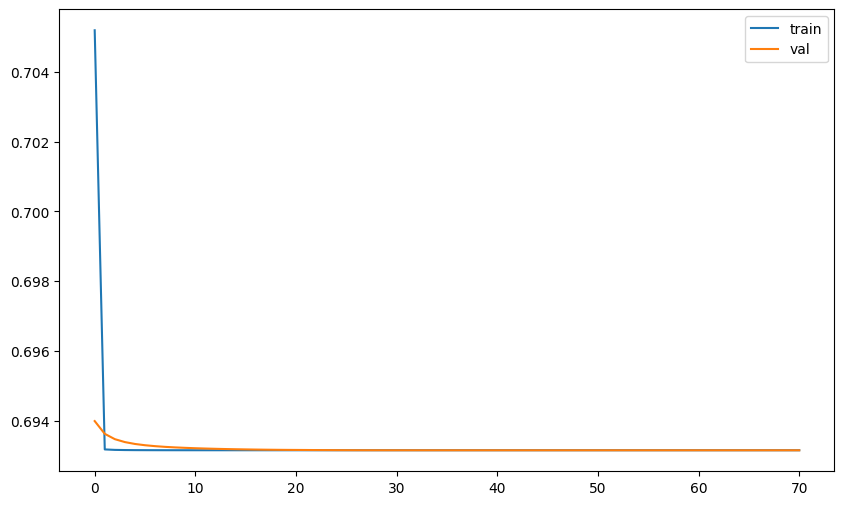

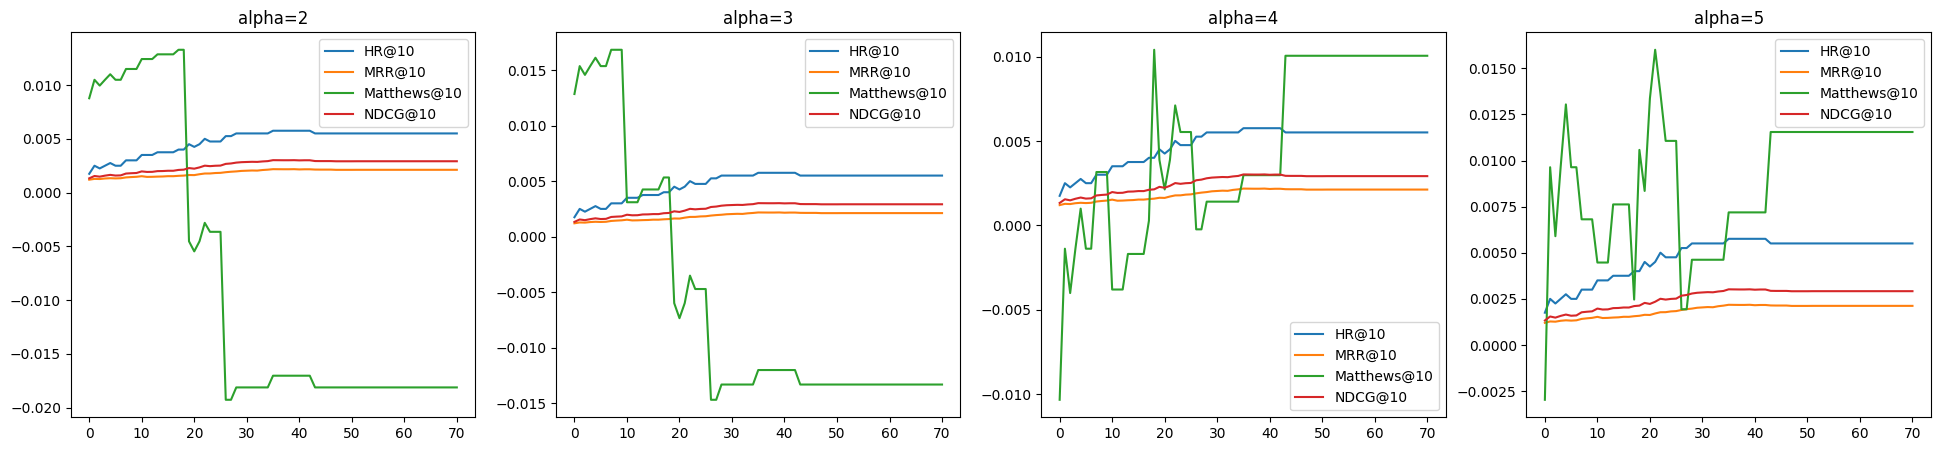

Test loss: 0.6931546330451965
Train loss: 0.6931472024535206


Hidden sizes: 1024
Current epoch 70
Results for alpha=2


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.005507,0.002824,0.146174,0.003495,0.005257,0.00025,0.002741,0.000083,0.00337,0.000125,-0.001261


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.007009,0.002997,0.262568,0.003952,0.006758,0.00025,0.002913,0.000083,0.003827,0.000125,0.002653


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.00826,0.003083,0.388048,0.004268,0.00801,0.00025,0.002999,0.000083,0.004143,0.000125,0.005343


Results for alpha=3


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.005507,0.002824,0.146174,0.003495,0.005257,0.00025,0.002741,0.000083,0.00337,0.000125,0.010784


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.007009,0.002997,0.262568,0.003952,0.006758,0.00025,0.002913,0.000083,0.003827,0.000125,0.015092


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.00826,0.003083,0.388048,0.004268,0.00801,0.00025,0.002999,0.000083,0.004143,0.000125,0.018155


Results for alpha=4


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.005507,0.003254,0.137391,0.003818,0.005006,0.000501,0.003108,0.000146,0.003585,0.000233,0.01868


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.006258,0.003341,0.240561,0.004048,0.005757,0.000501,0.003195,0.000146,0.003815,0.000233,0.022131


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.007509,0.003425,0.359883,0.004361,0.006758,0.000751,0.00326,0.000165,0.004062,0.000299,0.019817


Results for alpha=5


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.005507,0.003254,0.137391,0.003818,0.004255,0.001252,0.002524,0.00073,0.00296,0.000859,0.02539


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.006258,0.003341,0.240561,0.004048,0.005006,0.001252,0.002611,0.00073,0.003189,0.000859,0.031505


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.007509,0.003425,0.359883,0.004361,0.005757,0.001752,0.002662,0.000763,0.003378,0.000983,0.0286


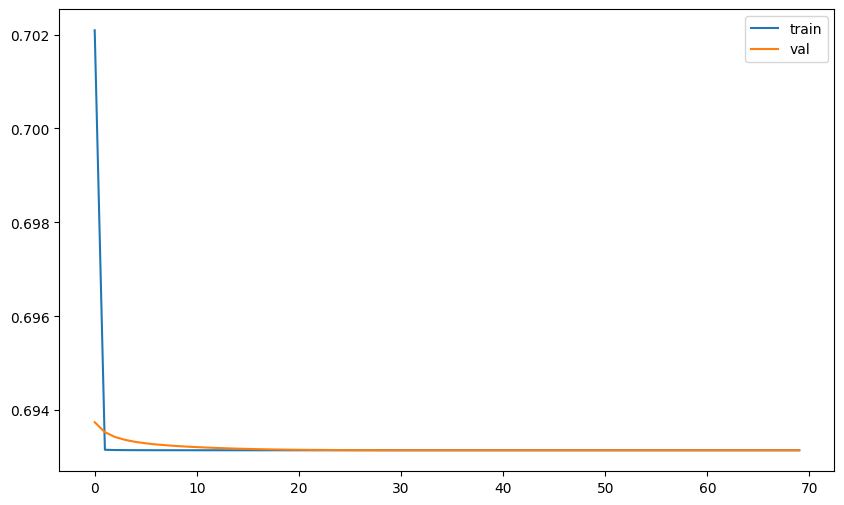

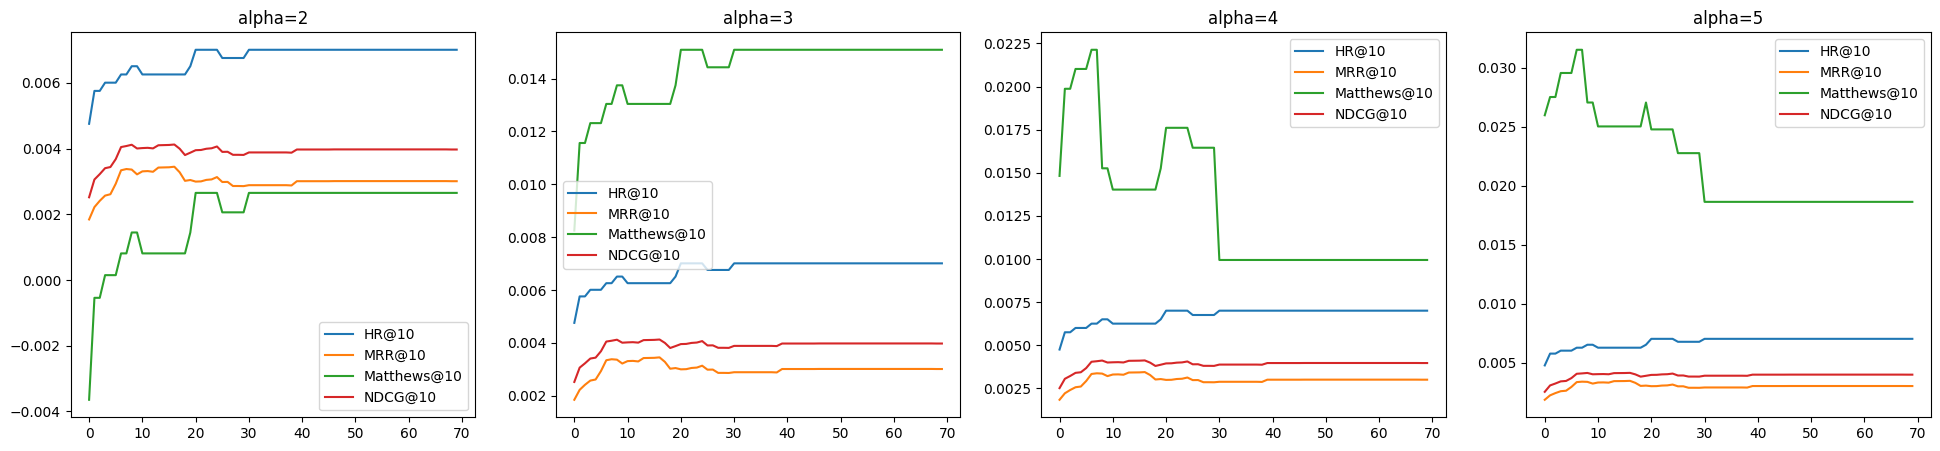

Test loss: 0.6931573748588562
Train loss: 0.6931471976735613




  0%|          | 0/7 [00:00<?, ?it/s]

Hidden sizes: 16
Current epoch 94
Results for alpha=2


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.001752,0.001114,0.00535,0.001271,0.001752,0.0,0.001114,0.0,0.001271,0.0,0.008778


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.003504,0.001322,0.010398,0.001812,0.003504,0.0,0.001322,0.0,0.001812,0.0,0.012425


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.005006,0.001412,0.016253,0.002174,0.005006,0.0,0.001412,0.0,0.002174,0.0,0.014862


Results for alpha=3


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.001752,0.001114,0.00535,0.001271,0.001752,0.0,0.001114,0.0,0.001271,0.0,0.01286


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.003504,0.001322,0.010398,0.001812,0.003504,0.0,0.001322,0.0,0.001812,0.0,0.018203


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.005006,0.001412,0.016253,0.002174,0.005006,0.0,0.001412,0.0,0.002174,0.0,0.021773


Results for alpha=4


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.001752,0.001114,0.00535,0.001271,0.001752,0.0,0.001114,0.0,0.001271,0.0,0.020241


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.003504,0.001322,0.010398,0.001812,0.003504,0.0,0.001322,0.0,0.001812,0.0,0.02865


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.005006,0.001412,0.016253,0.002174,0.005006,0.0,0.001412,0.0,0.002174,0.0,0.034269


Results for alpha=5


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.001752,0.001114,0.00535,0.001271,0.001752,0.0,0.001114,0.0,0.001271,0.0,0.033781


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.003504,0.001322,0.010398,0.001812,0.003504,0.0,0.001322,0.0,0.001812,0.0,0.047816


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.005006,0.001412,0.016253,0.002174,0.004756,0.00025,0.001397,0.000016,0.002113,0.000061,0.049936


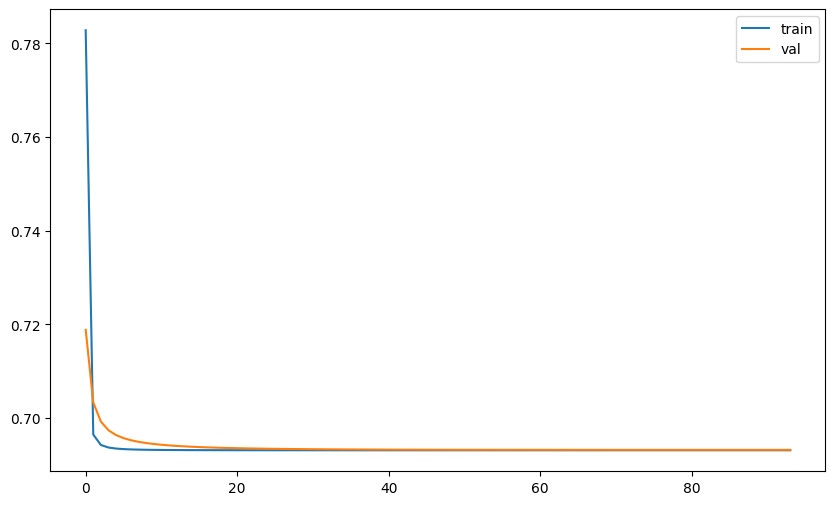

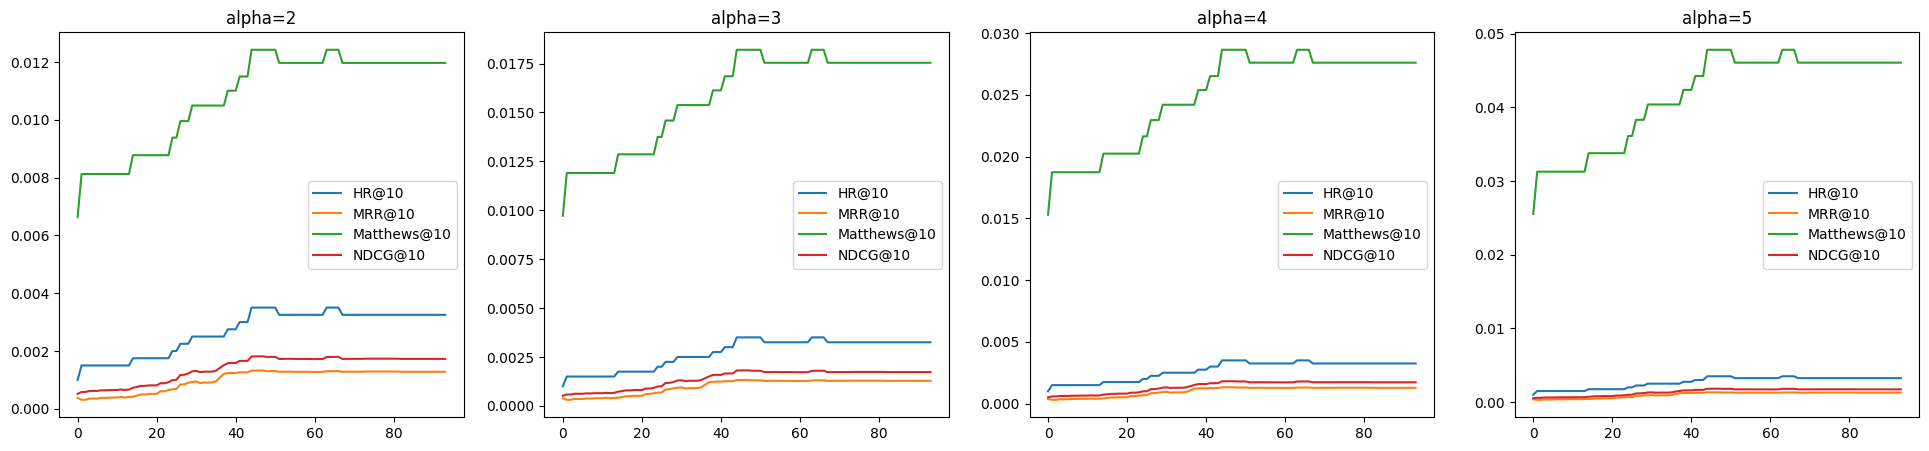

Test loss: 0.6932674050331116
Train loss: 0.693149675588006


Hidden sizes: 32
Current epoch 87
Results for alpha=2


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.002503,0.001773,0.005653,0.001958,0.002503,0.0,0.001773,0.0,0.001958,0.0,0.010496


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.005006,0.002094,0.012013,0.002755,0.005006,0.0,0.002094,0.0,0.002755,0.0,0.014862


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.00801,0.002294,0.020594,0.003503,0.00776,0.00025,0.002276,0.000018,0.003439,0.000064,0.004836


Results for alpha=3


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.002503,0.001773,0.005653,0.001958,0.002503,0.0,0.001773,0.0,0.001958,0.0,0.015377


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.005006,0.002094,0.012013,0.002755,0.005006,0.0,0.002094,0.0,0.002755,0.0,0.021773


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.00801,0.002294,0.020594,0.003503,0.00776,0.00025,0.002276,0.000018,0.003439,0.000064,0.017572


Results for alpha=4


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.002503,0.001544,0.005754,0.001783,0.002503,0.0,0.001544,0.0,0.001783,0.0,0.024201


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.004255,0.001759,0.012114,0.002331,0.004255,0.0,0.001759,0.0,0.002331,0.0,0.031583


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.007509,0.001993,0.020493,0.003165,0.007009,0.000501,0.001954,0.000039,0.003033,0.000132,0.027219


Results for alpha=5


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.002503,0.001544,0.005754,0.001783,0.002253,0.00025,0.00146,0.000083,0.001658,0.000125,0.03014


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.004255,0.001759,0.012114,0.002331,0.003755,0.000501,0.001644,0.000115,0.002127,0.000204,0.036971


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.007509,0.001993,0.020493,0.003165,0.006008,0.001502,0.001812,0.000181,0.002711,0.000454,0.034534


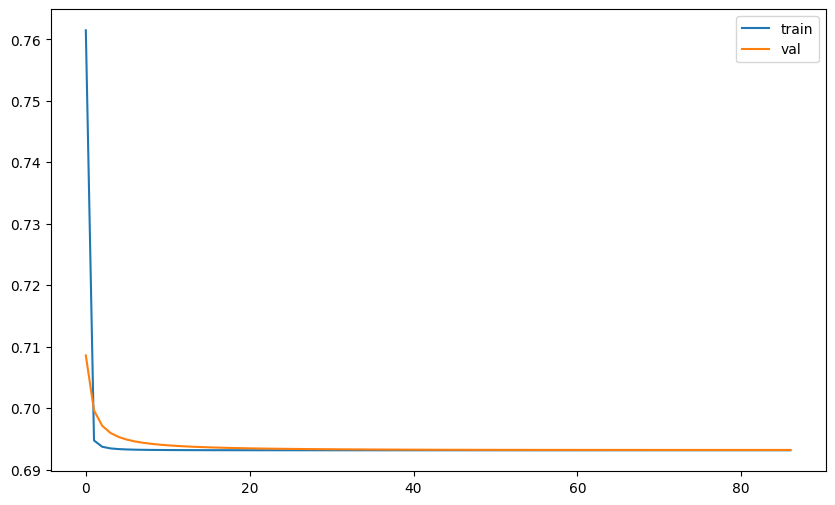

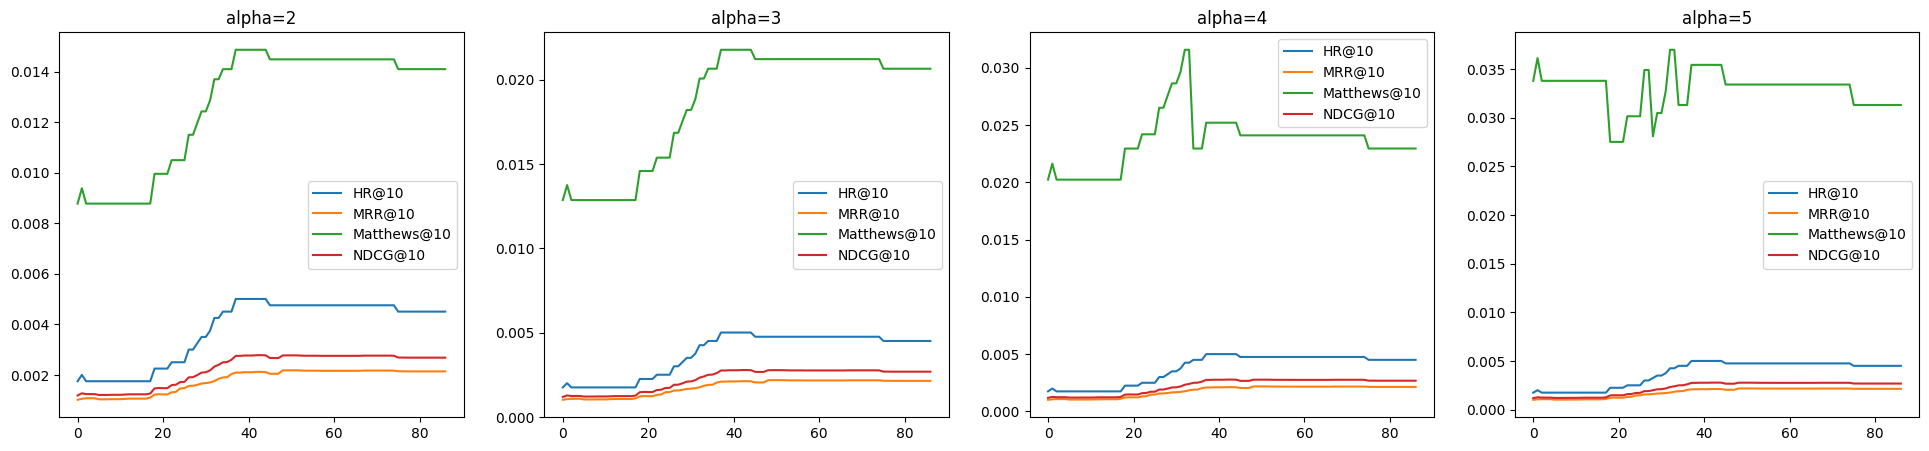

Test loss: 0.6932615637779236
Train loss: 0.6931493114499212


Hidden sizes: 64
Current epoch 114
Results for alpha=2


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.004506,0.002457,0.006461,0.002968,0.004255,0.00025,0.002332,0.000125,0.002811,0.000158,-0.004526


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.006008,0.002638,0.013426,0.003433,0.005757,0.00025,0.002512,0.000125,0.003276,0.000158,0.000149


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.00801,0.002785,0.024833,0.00395,0.007259,0.000751,0.002622,0.000163,0.003662,0.000288,-0.023145


Results for alpha=3


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.004506,0.002457,0.006461,0.002968,0.004005,0.000501,0.002082,0.000375,0.00256,0.000408,-0.005996


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.006008,0.002638,0.013426,0.003433,0.005507,0.000501,0.002262,0.000375,0.003025,0.000408,0.000769


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.00801,0.002785,0.024833,0.00395,0.006758,0.001252,0.002358,0.000427,0.003353,0.000597,-0.022469


Results for alpha=4


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.004506,0.002457,0.006461,0.002968,0.003254,0.001252,0.001623,0.000834,0.002027,0.000942,-0.015207


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.006008,0.002638,0.013426,0.003433,0.004756,0.001252,0.001803,0.000834,0.002492,0.000942,-0.00379


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.00801,0.002785,0.024833,0.00395,0.005757,0.002253,0.001881,0.000904,0.002755,0.001194,-0.021109


Results for alpha=5


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.004255,0.002228,0.005855,0.002728,0.001502,0.002753,0.000676,0.001552,0.000881,0.001847,-0.033857


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.005257,0.002364,0.013022,0.003055,0.002503,0.002753,0.000812,0.001552,0.001207,0.001847,-0.019313


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.00826,0.002589,0.024329,0.003835,0.003504,0.004756,0.000895,0.001695,0.001477,0.002358,-0.033949


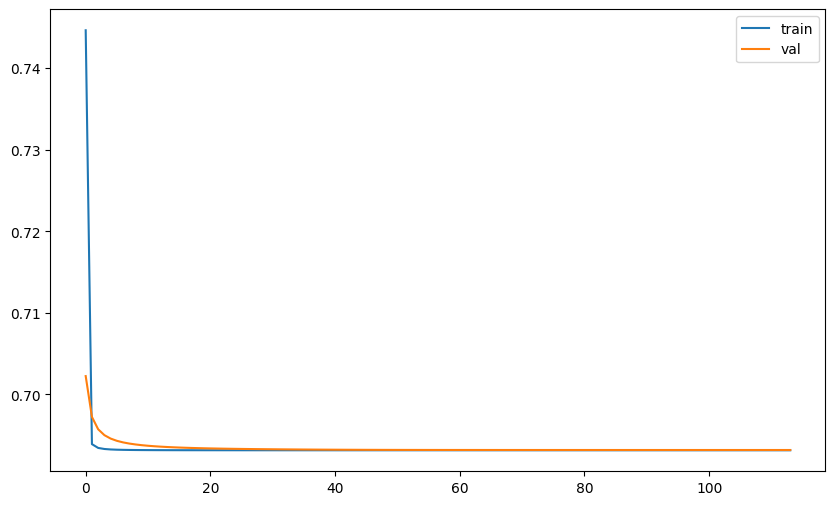

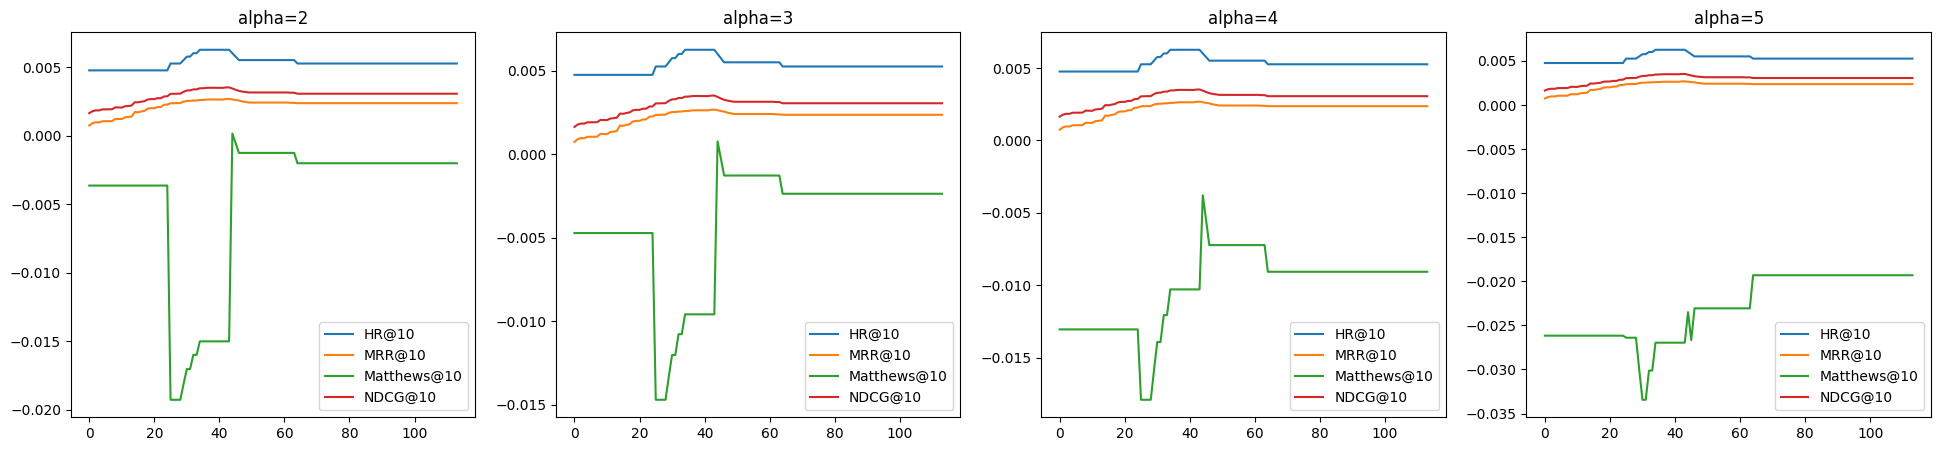

Test loss: 0.6931833624839783
Train loss: 0.6931476731902187


Hidden sizes: 128
Current epoch 110
Results for alpha=2


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.002503,0.001068,0.015243,0.001415,0.002503,0.0,0.001068,0.0,0.001415,0.0,0.010496


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.004506,0.00131,0.028064,0.002037,0.004506,0.0,0.00131,0.0,0.002037,0.0,0.014096


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.007259,0.001503,0.048455,0.002735,0.007259,0.0,0.001503,0.0,0.002735,0.0,0.017916


Results for alpha=3


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.002503,0.001068,0.015243,0.001415,0.002503,0.0,0.001068,0.0,0.001415,0.0,0.015377


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.004506,0.00131,0.028064,0.002037,0.004506,0.0,0.00131,0.0,0.002037,0.0,0.020651


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.007259,0.001503,0.048455,0.002735,0.007009,0.00025,0.001485,0.000018,0.002671,0.000064,0.015737


Results for alpha=4


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.002503,0.001068,0.015243,0.001415,0.002503,0.0,0.001068,0.0,0.001415,0.0,0.024201


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.004506,0.00131,0.028064,0.002037,0.004506,0.0,0.00131,0.0,0.002037,0.0,0.032502


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.007259,0.001503,0.048455,0.002735,0.006758,0.000501,0.001469,0.000034,0.00261,0.000125,0.026256


Results for alpha=5


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.002503,0.001068,0.01595,0.001415,0.002003,0.000501,0.00088,0.000188,0.001149,0.000266,0.019888


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.004005,0.001253,0.028972,0.001885,0.003504,0.000501,0.001065,0.000188,0.001619,0.000266,0.034908


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.006758,0.001447,0.050273,0.002584,0.004756,0.002003,0.001158,0.000288,0.001943,0.000641,0.016493


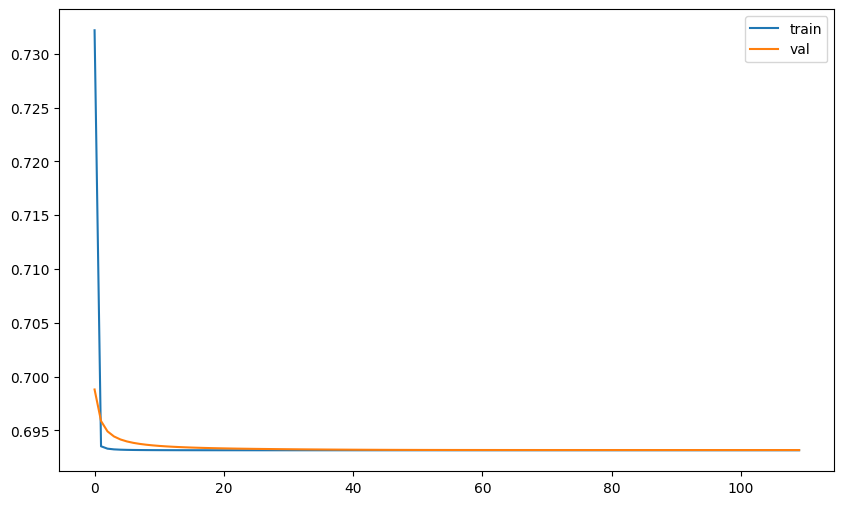

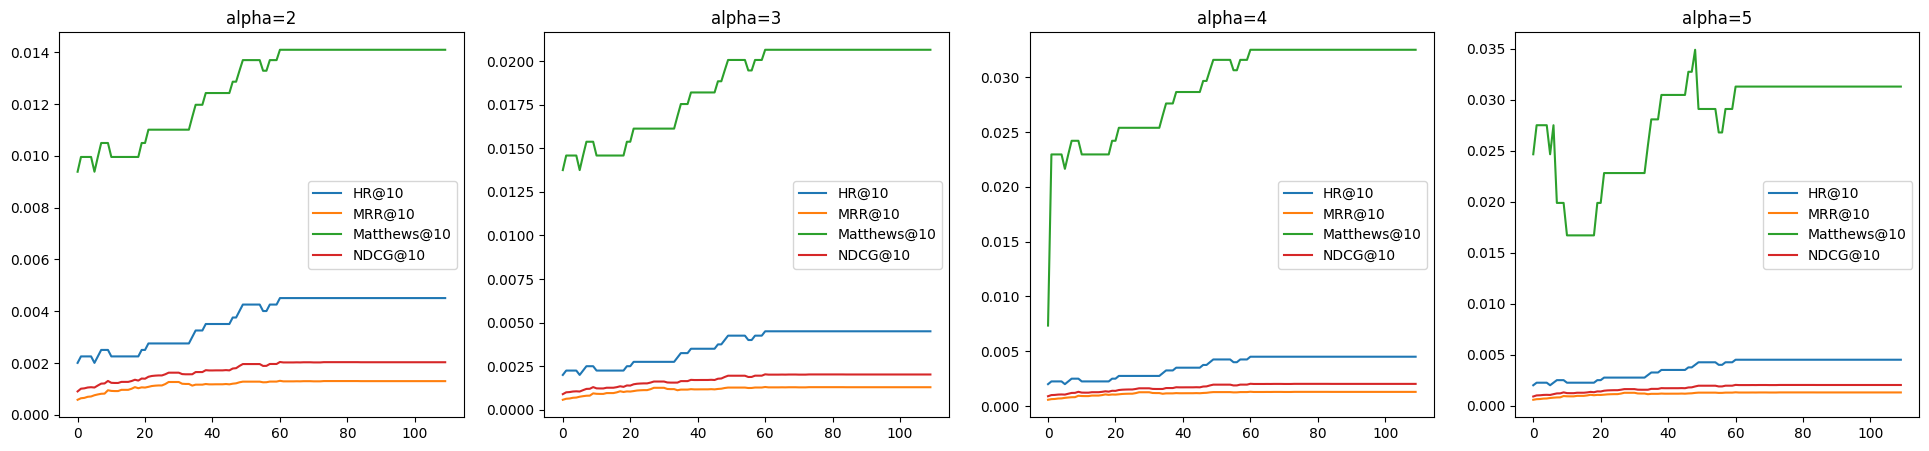

Test loss: 0.6931723952293396
Train loss: 0.6931474603784894


Hidden sizes: 256
Current epoch 101
Results for alpha=2


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.003004,0.001101,0.031395,0.001565,0.003004,0.0,0.001101,0.0,0.001565,0.0,0.0115


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.006508,0.001538,0.056128,0.002665,0.006508,0.0,0.001538,0.0,0.002665,0.0,0.016958


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.010263,0.001786,0.093882,0.003598,0.010263,0.0,0.001786,0.0,0.003598,0.0,0.021335


Results for alpha=3


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.003004,0.001101,0.031395,0.001565,0.003004,0.0,0.001101,0.0,0.001565,0.0,0.016848


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.006508,0.001538,0.056128,0.002665,0.006508,0.0,0.001538,0.0,0.002665,0.0,0.024844


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.010263,0.001786,0.093882,0.003598,0.010263,0.0,0.001786,0.0,0.003598,0.0,0.031257


Results for alpha=4


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.002753,0.001135,0.034121,0.001537,0.002753,0.0,0.001135,0.0,0.001537,0.0,0.025386


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.006008,0.001528,0.060166,0.002547,0.006008,0.0,0.001528,0.0,0.002547,0.0,0.037559


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.011514,0.001889,0.101555,0.003913,0.011014,0.000501,0.001855,0.000034,0.003787,0.000126,0.040162


Results for alpha=5


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.002503,0.001314,0.036644,0.001616,0.002253,0.00025,0.001189,0.000125,0.001458,0.000158,0.03014


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.005257,0.001656,0.061781,0.00248,0.004506,0.000751,0.001481,0.000175,0.002177,0.000303,0.037361


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.011765,0.002085,0.10529,0.004096,0.008761,0.003004,0.001755,0.000329,0.003227,0.000869,0.030965


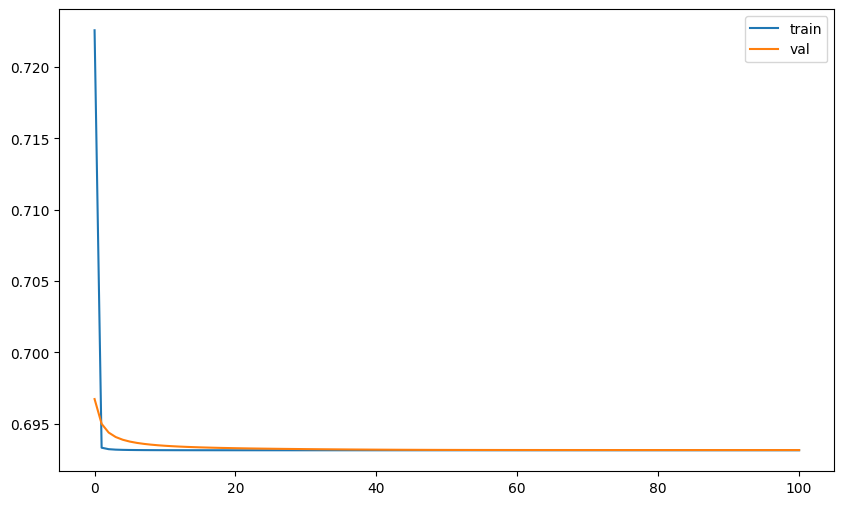

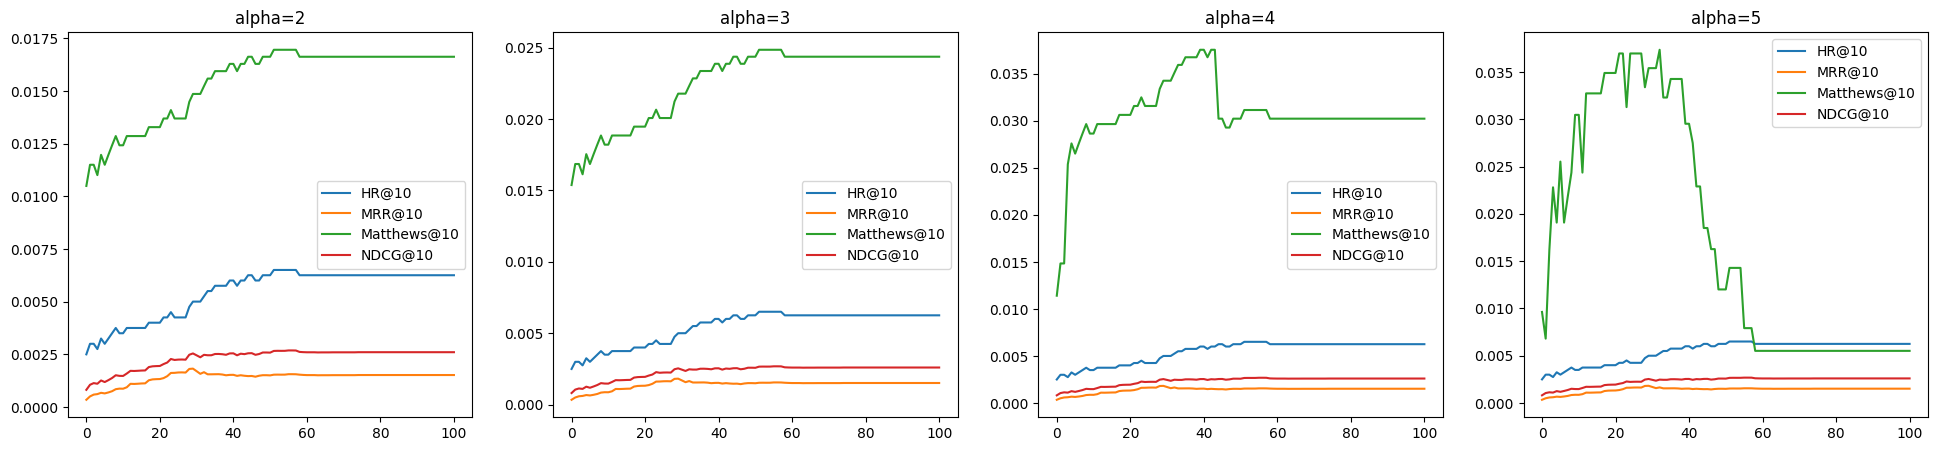

Test loss: 0.693171501159668
Train loss: 0.6931473850046547


Hidden sizes: 512
Current epoch 118
Results for alpha=2


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.004005,0.001648,0.065819,0.002217,0.004005,0.0,0.001648,0.0,0.002217,0.0,0.013286


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.007009,0.002061,0.114678,0.0032,0.006508,0.000501,0.001998,0.000063,0.003042,0.000158,-0.012296


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.012265,0.002392,0.185645,0.004487,0.011514,0.000751,0.002317,0.000075,0.004272,0.000215,-0.010644


Results for alpha=3


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.004005,0.001648,0.065819,0.002217,0.004005,0.0,0.001648,0.0,0.002217,0.0,0.019465


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.007009,0.002061,0.114678,0.0032,0.006508,0.000501,0.001998,0.000063,0.003042,0.000158,0.004396


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.012265,0.002392,0.185645,0.004487,0.011514,0.000751,0.002317,0.000075,0.004272,0.000215,0.009885


Results for alpha=4


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.002753,0.001677,0.079548,0.001939,0.002753,0.0,0.001677,0.0,0.001939,0.0,0.025386


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.004506,0.001902,0.128912,0.002498,0.004005,0.000501,0.001833,0.00007,0.002333,0.000165,0.013418


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.006258,0.002012,0.206642,0.002925,0.005257,0.001001,0.001906,0.000106,0.002632,0.000293,0.005923


Results for alpha=5


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.002753,0.001677,0.079548,0.001939,0.002503,0.00025,0.001427,0.00025,0.001689,0.00025,0.032592


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.004506,0.001902,0.128912,0.002498,0.003755,0.000751,0.001582,0.00032,0.002083,0.000415,0.031299


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.006258,0.002012,0.206642,0.002925,0.004756,0.001502,0.001641,0.00037,0.002323,0.000603,0.025009


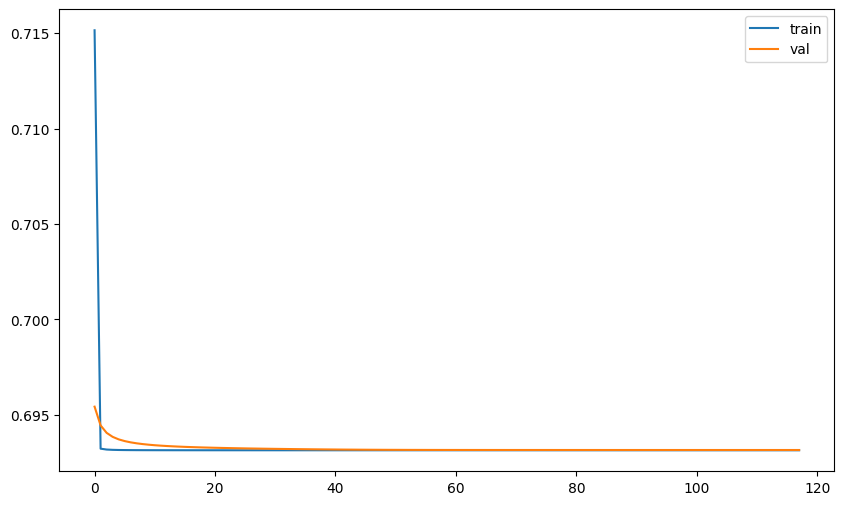

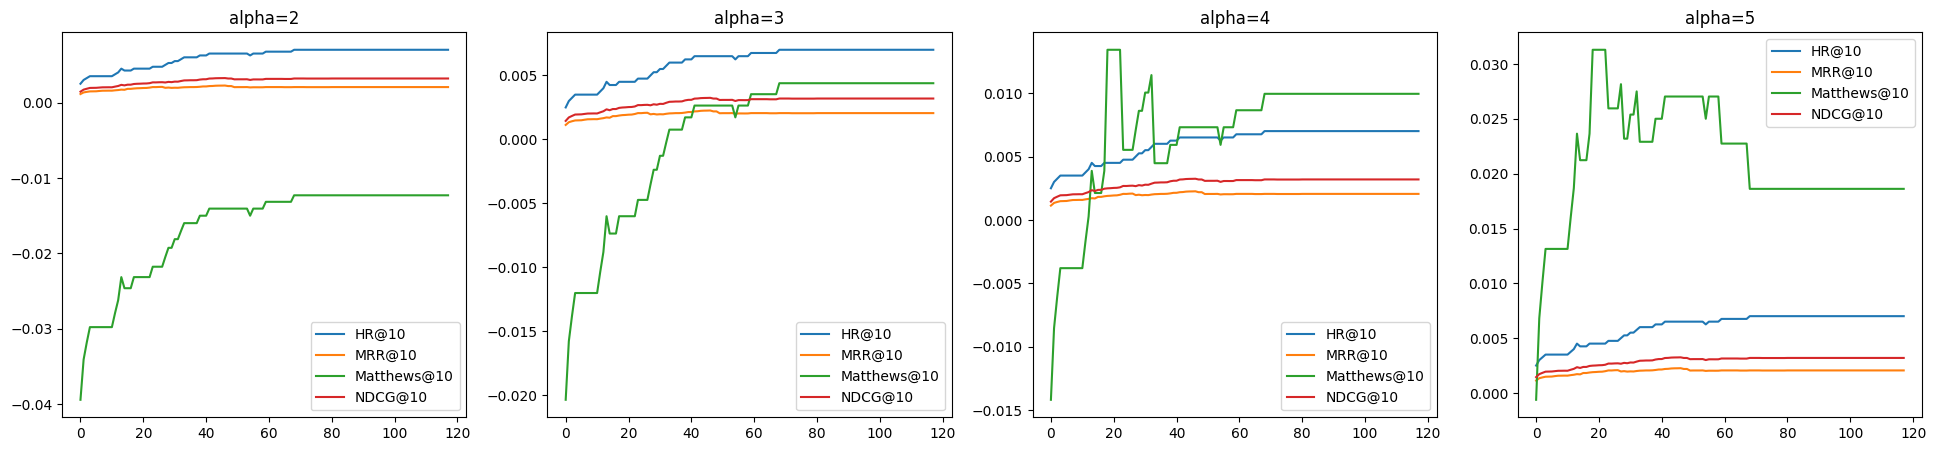

Test loss: 0.6931623220443726
Train loss: 0.6931472717268953


Hidden sizes: 1024
Current epoch 94
Results for alpha=2


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.001752,0.001176,0.15849,0.001314,0.001752,0.0,0.001176,0.0,0.001314,0.0,0.008778


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.003004,0.001343,0.247628,0.001717,0.003004,0.0,0.001343,0.0,0.001717,0.0,0.0115


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.004255,0.001418,0.354936,0.00202,0.004255,0.0,0.001418,0.0,0.00202,0.0,0.013697


Results for alpha=3


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.001752,0.001176,0.15849,0.001314,0.001752,0.0,0.001176,0.0,0.001314,0.0,0.01286


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.003004,0.001343,0.247628,0.001717,0.003004,0.0,0.001343,0.0,0.001717,0.0,0.016848


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.004255,0.001418,0.354936,0.00202,0.004255,0.0,0.001418,0.0,0.00202,0.0,0.020066


Results for alpha=4


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.001752,0.001176,0.15849,0.001314,0.001752,0.0,0.001176,0.0,0.001314,0.0,0.020241


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.003004,0.001343,0.247628,0.001717,0.003004,0.0,0.001343,0.0,0.001717,0.0,0.026518


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.004255,0.001418,0.354936,0.00202,0.004005,0.00025,0.001405,0.000013,0.001962,0.000058,0.021765


Results for alpha=5


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.001252,0.001064,0.130729,0.001109,0.001001,0.00025,0.000814,0.00025,0.000859,0.00025,0.014054


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.002253,0.001183,0.201494,0.001418,0.002003,0.00025,0.000933,0.00025,0.001168,0.00025,0.027509


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.003004,0.001233,0.293559,0.001605,0.002753,0.00025,0.000983,0.00025,0.001355,0.00025,0.034897


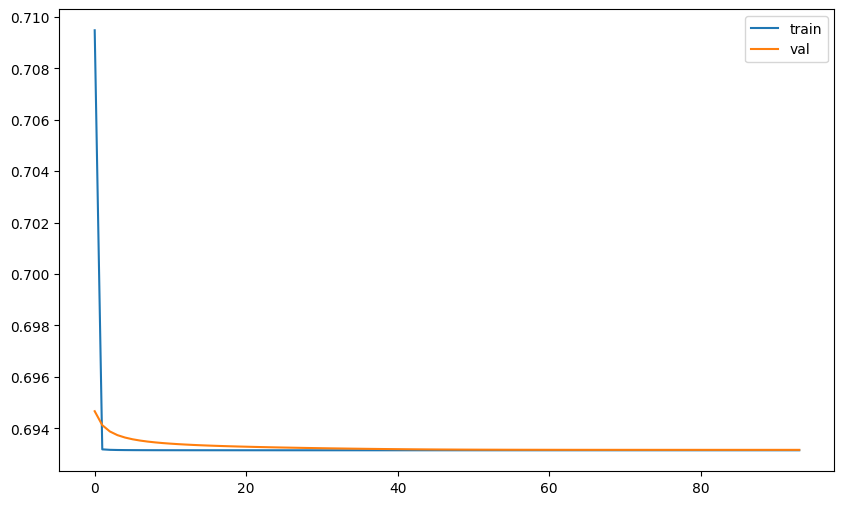

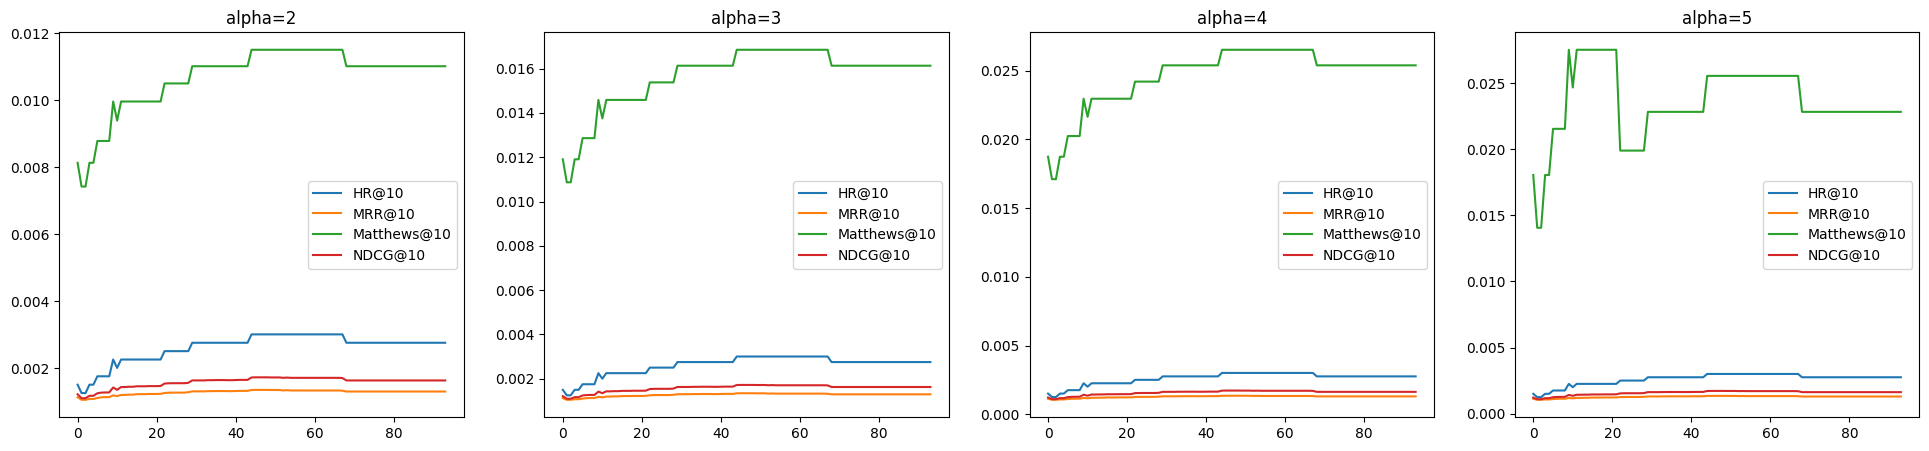

Test loss: 0.6931806206703186
Train loss: 0.6931473031206038




  0%|          | 0/7 [00:00<?, ?it/s]

Hidden sizes: 16


C:\Users\Liza\Desktop\Thesis\utils.py:68: RuntimeWarning: invalid value encountered in double_scalars
  C = (TP/N - S*P) / np.sqrt(P*S*(1-P)*(1-S))
C:\Users\Liza\Desktop\Thesis\utils.py:68: RuntimeWarning: invalid value encountered in double_scalars
  C = (TP/N - S*P) / np.sqrt(P*S*(1-P)*(1-S))
C:\Users\Liza\Desktop\Thesis\utils.py:68: RuntimeWarning: invalid value encountered in double_scalars
  C = (TP/N - S*P) / np.sqrt(P*S*(1-P)*(1-S))
C:\Users\Liza\Desktop\Thesis\utils.py:68: RuntimeWarning: invalid value encountered in double_scalars
  C = (TP/N - S*P) / np.sqrt(P*S*(1-P)*(1-S))
C:\Users\Liza\Desktop\Thesis\utils.py:68: RuntimeWarning: invalid value encountered in double_scalars
  C = (TP/N - S*P) / np.sqrt(P*S*(1-P)*(1-S))
C:\Users\Liza\Desktop\Thesis\utils.py:68: RuntimeWarning: invalid value encountered in double_scalars
  C = (TP/N - S*P) / np.sqrt(P*S*(1-P)*(1-S))
C:\Users\Liza\Desktop\Thesis\utils.py:68: RuntimeWarning: invalid value encountered in double_scalars
  C = (TP/

Current epoch 50
Results for alpha=2


C:\Users\Liza\Desktop\Thesis\utils.py:68: RuntimeWarning: invalid value encountered in double_scalars
  C = (TP/N - S*P) / np.sqrt(P*S*(1-P)*(1-S))


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.0,0.0,0.001615,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.00025,0.000028,0.003735,0.000075,0.00025,0.0,0.000028,0.0,0.000075,0.0,0.003315


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.000751,0.000066,0.008682,0.000206,0.000751,0.0,0.000066,0.0,0.000206,0.0,0.005744


Results for alpha=3


C:\Users\Liza\Desktop\Thesis\utils.py:68: RuntimeWarning: invalid value encountered in double_scalars
  C = (TP/N - S*P) / np.sqrt(P*S*(1-P)*(1-S))


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.0,0.0,0.001615,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.00025,0.000028,0.003735,0.000075,0.0,0.00025,0.0,0.000028,0.0,0.000075,-0.051549


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.000751,0.000066,0.008682,0.000206,0.000501,0.00025,0.000038,0.000028,0.000131,0.000075,-0.02416


Results for alpha=4


C:\Users\Liza\Desktop\Thesis\utils.py:68: RuntimeWarning: invalid value encountered in double_scalars
  C = (TP/N - S*P) / np.sqrt(P*S*(1-P)*(1-S))


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.0,0.0,0.001615,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.00025,0.000028,0.003735,0.000075,0.0,0.00025,0.0,0.000028,0.0,0.000075,-0.032752


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.000751,0.000066,0.008682,0.000206,0.000501,0.00025,0.000038,0.000028,0.000131,0.000075,-0.010085


Results for alpha=5


C:\Users\Liza\Desktop\Thesis\utils.py:68: RuntimeWarning: invalid value encountered in double_scalars
  C = (TP/N - S*P) / np.sqrt(P*S*(1-P)*(1-S))


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.0,0.0,0.001615,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.00025,0.000028,0.003735,0.000075,0.0,0.00025,0.0,0.000028,0.0,0.000075,-0.019624


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.000751,0.000066,0.008682,0.000206,0.000501,0.00025,0.000038,0.000028,0.000131,0.000075,0.003403


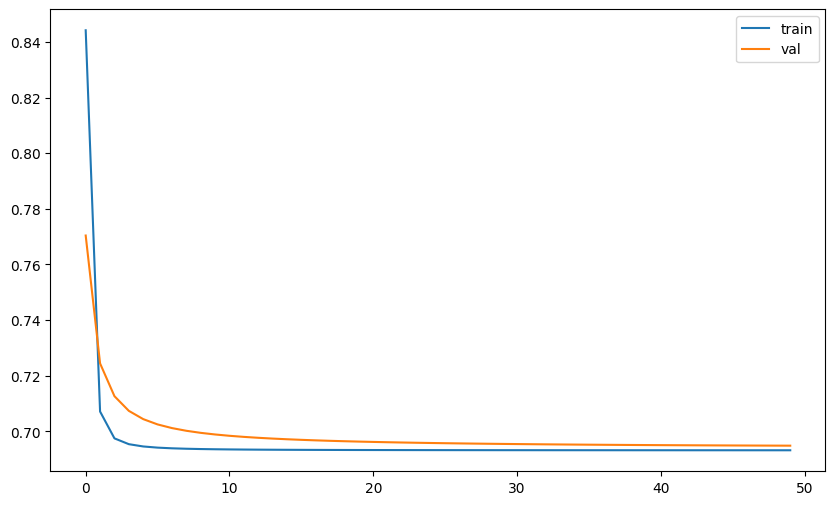

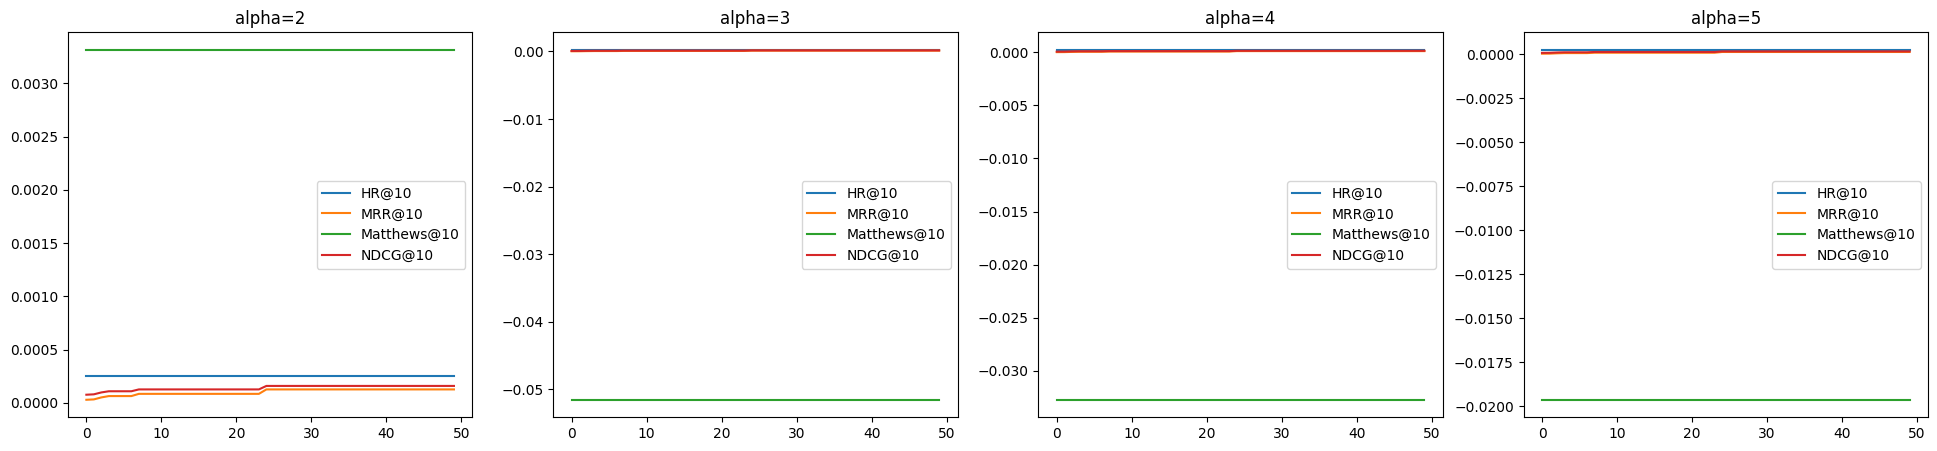

Test loss: 0.7704112529754639
Train loss: 0.8442039452131512


Hidden sizes: 32


KeyboardInterrupt: 

In [20]:
sizes = 2**np.arange(4,10)
for batch_size in sizes:
    tuning_pipeline(training, testset_valid, holdout_valid, data_description, base_model, device, grid, batch_size=batch_size)

In [ ]:
sizes = 2**np.arange(4,10)
for batch_size in sizes:
    tuning_pipeline_augment(training, testset_valid, holdout_valid, data_description, base_model, grid, device, MVDataset, batch_size=batch_size)

## VAE

In [70]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [97]:
alpha = 3

# training
vae_training = training[training['rating']>=alpha]
n_users = vae_training['userid'].max()+1
n_items = data_description['n_items']

rows, cols = vae_training['userid'], vae_training['movieid']
vae_train_data = sparse.csr_matrix((np.ones_like(rows),
                         (rows, cols)), dtype='float64',
                         shape=(n_users, n_items))

# validation
start_idx = min(testset_valid['userid'].min(), holdout_valid['userid'].min())
end_idx = max(testset_valid['userid'].max(), holdout_valid['userid'].max())

rows_tr, cols_tr = testset_valid['userid'] - start_idx, testset_valid['movieid']
rows_te, cols_te = holdout_valid['userid'] - start_idx, holdout_valid['movieid']

valid_in_data = sparse.csr_matrix((np.ones_like(rows_tr),
                         (rows_tr, cols_tr)), dtype='float64', shape=(end_idx - start_idx + 1, n_items))
valid_out_data = sparse.csr_matrix((np.ones_like(rows_te),
                         (rows_te, cols_te)), dtype='float64', shape=(end_idx - start_idx + 1, n_items))

# test
start_idx = min(testset['userid'].min(), holdout['userid'].min())
end_idx = max(testset['userid'].max(), holdout['userid'].max())

rows_tr, cols_tr = testset['userid'] - start_idx, testset['movieid']
rows_te, cols_te = holdout['userid'] - start_idx, holdout['movieid']

test_in_data = sparse.csr_matrix((np.ones_like(rows_tr),
                         (rows_tr, cols_tr)), dtype='float64', shape=(end_idx - start_idx + 1, n_items))
test_out_data = sparse.csr_matrix((np.ones_like(rows_te),
                         (rows_te, cols_te)), dtype='float64', shape=(end_idx - start_idx + 1, n_items))

In [105]:
np.sum(vae_train_data.A), np.sum(valid_in_data.A), np.sum(valid_out_data.A), np.sum(test_in_data.A), np.sum(test_out_data.A)

(462784.0, 196310.0, 1705.0, 198048.0, 1738.0)

In [129]:
def generate(batch_size, device, data_in, data_out=None, shuffle=False, samples_perc_per_epoch=1):
    assert 0 < samples_perc_per_epoch <= 1
    
    total_samples = data_in.shape[0]
    samples_per_epoch = int(total_samples * samples_perc_per_epoch)
    
    if shuffle:
        idxlist = np.arange(total_samples)
        np.random.shuffle(idxlist)
        idxlist = idxlist[:samples_per_epoch]
    else:
        idxlist = np.arange(samples_per_epoch)
    
    for st_idx in range(0, samples_per_epoch, batch_size):
        end_idx = min(st_idx + batch_size, samples_per_epoch)
        idx = idxlist[st_idx:end_idx]

        yield Batch(device, idx, data_in, data_out)


class Batch:
    def __init__(self, device, idx, data_in, data_out=None):
        self._device = device
        self._idx = idx
        self._data_in = data_in
        self._data_out = data_out
    
    def get_idx(self):
        return self._idx
    
    def get_idx_to_dev(self):
        return torch.LongTensor(self.get_idx()).to(self._device)
        
    def get_ratings(self, is_out=False):
        data = self._data_out if is_out else self._data_in
        return data[self._idx]
    
    def get_ratings_to_dev(self, is_out=False):
        return torch.Tensor(
            self.get_ratings(is_out).toarray()
        ).to(self._device)


def evaluate(model, data_in, data_out, metrics, samples_perc_per_epoch=1, batch_size=500):
    metrics = deepcopy(metrics)
    model.eval()
    
    for m in metrics:
        m['score'] = []
    
    for batch in generate(batch_size=batch_size,
                          device=device,
                          data_in=data_in,
                          data_out=data_out,
                          samples_perc_per_epoch=samples_perc_per_epoch
                         ):
        ratings_in = batch.get_ratings_to_dev()
#         print(ratings_in)
        ratings_out = batch.get_ratings(is_out=True)
#         print(ratings_out)
    
        ratings_pred = model(ratings_in, calculate_loss=False).cpu().detach().numpy()
#         print(ratings_pred)
        
        if not (data_in is data_out):
            ratings_pred[batch.get_ratings().nonzero()] = -np.inf
            
        for m in metrics:
            m['score'].append(m['metric'](ratings_pred, ratings_out, k=m['k']))

    for m in metrics:
        m['score'] = np.concatenate(m['score']).mean()
        
    return [x['score'] for x in metrics]


def run(model, opts, train_data, batch_size, n_epochs, beta, gamma, dropout_rate):
    model.train()
    for epoch in range(n_epochs):
        for batch in generate(batch_size=batch_size, device=device, data_in=train_data, shuffle=True):
            ratings = batch.get_ratings_to_dev()
#             print(ratings)

            for optimizer in opts:
                optimizer.zero_grad()
                
            a, loss = model(ratings, beta=beta, gamma=gamma, dropout_rate=dropout_rate)
            print(a, loss)
#             print(loss)
            loss.backward()
            
            for optimizer in opts:
                optimizer.step()

In [130]:
grid1 = np.arange(100, 2100, 100)
grid = np.meshgrid(grid1, grid1)

In [131]:
model_kwargs = {
    'hidden_dim': 100,
    'latent_dim': 100,
    'input_dim': vae_train_data.shape[1]
}
metrics = [{'metric': ndcg, 'k': 10}]

best_ndcg = -np.inf
train_scores, valid_scores = [], []

model = RecVAE(**model_kwargs).to(device)
model_best = RecVAE(**model_kwargs).to(device)

learning_kwargs = {
    'model': model,
    'train_data': vae_train_data,
    'batch_size': 512,
    'beta': None,
    'gamma': 0.005
}

decoder_params = set(model.decoder.parameters())
encoder_params = set(model.encoder.parameters())

optimizer_encoder = optim.Adam(encoder_params, lr=5e-4)
optimizer_decoder = optim.Adam(decoder_params, lr=5e-4)

n_epochs = 50

for epoch in range(n_epochs):

    run(opts=[optimizer_encoder], n_epochs=3, dropout_rate=0.5, **learning_kwargs)
    model.update_prior()
    run(opts=[optimizer_decoder], n_epochs=1, dropout_rate=0, **learning_kwargs)

    train_scores.append(
        evaluate(model, vae_train_data, vae_train_data, metrics, 0.01)[0]
    )
    valid_scores.append(
        evaluate(model, valid_in_data, valid_out_data, metrics, 1)[0]
    )
    
    if valid_scores[-1] > best_ndcg:
        best_ndcg = valid_scores[-1]
        model_best.load_state_dict(deepcopy(model.state_dict()))
        

    print(f'epoch {epoch} | valid ndcg@100: {valid_scores[-1]:.4f} | ' +
          f'best valid: {best_ndcg:.4f} | train ndcg@100: {train_scores[-1]:.4f}')


    
test_metrics = [{'metric': ndcg, 'k': 100}, {'metric': recall, 'k': 20}, {'metric': recall, 'k': 50}]

final_scores = evaluate(model_best, test_in_data, test_out_data, test_metrics)

for metric, score in zip(test_metrics, final_scores):
    print(f"{metric['metric'].__name__}@{metric['k']}:\t{score:.4f}")

(tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>), tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>)) tensor(nan, device='cuda:0', grad_fn=<NegBackward0>)
(tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>), tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>)) tensor(nan, device='cuda:0', grad_fn=<NegBackward0>)
(tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>), tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>)) tensor(nan, device='cuda:0', grad_fn=<NegBackward0>)
(tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>), tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>)) tensor(nan, device='cuda:0', grad_fn=<NegBackward0>)
(tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>), tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>)) tensor(nan, device='cuda:0', grad_fn=<NegBackward0>)
(tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>), tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>)) tensor(nan, device='cuda:0', grad_fn=<NegBackward0>)
(tensor(nan, dev

C:\Users\Liza\Desktop\Thesis\RecVAE\utils.py:98: RuntimeWarning: invalid value encountered in true_divide
  return DCG / IDCG


epoch 0 | valid ndcg@100: nan | best valid: -inf | train ndcg@100: 0.0184
(tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>), tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>)) tensor(nan, device='cuda:0', grad_fn=<NegBackward0>)
(tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>), tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>)) tensor(nan, device='cuda:0', grad_fn=<NegBackward0>)
(tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>), tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>)) tensor(nan, device='cuda:0', grad_fn=<NegBackward0>)
(tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>), tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>)) tensor(nan, device='cuda:0', grad_fn=<NegBackward0>)
(tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>), tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>)) tensor(nan, device='cuda:0', grad_fn=<NegBackward0>)
(tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>), tensor(nan, device='cuda:0', grad_fn=<MeanBackward

KeyboardInterrupt: 

In [106]:
valid_scores

[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]

In [ ]:
params = []
histories = []
test_losses = []
mrrs = []
hrs = []
cs = []


for h1, h2, in tqdm(zip(grid[0].flatten(), grid[1].flatten()), total=24):
    print('Hidden sizes:', h1, h2)
    
    vae = VAE(data_description['n_items'], data_description['n_ratings'], h1, h2).to(device)
    criterion = nn.BCEWithLogitsLoss().to(device)
    optimizer = optim.Adam(ae.parameters(), lr=5*1e-4)
    
    mask = torch.triu(torch.ones_like(ae.L.weight))
    # Register with hook
    ae.L.weight.register_hook(get_zero_grad_hook(mask))
    
    params.append(sum(p.numel() for p in ae.parameters() if p.requires_grad))
    
    # Training the AE
    n_epochs = 20
    history = []
    prev_train_loss = 1
    train_loss = 0.1 * len(train_dataloader)
    epoch = 1

    while prev_train_loss - train_loss / len(train_dataloader) > 1e-4 or train_loss / len(train_dataloader) > 1e-2:
        if epoch > 1:
            prev_train_loss = train_loss / len(train_dataloader)
        
        train_loss = 0
        for batch in train_dataloader:
            optimizer.zero_grad()

            user_tensor, user_matrix = batch

            input_tensor = user_tensor.to_dense().to(device)
            target = user_matrix.to_dense().to(device)

            output = ae(input_tensor)
            target.require_grad = False # we don't use it in training

            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.data.item()

        history.append(train_loss / len(train_dataloader))
        epoch += 1
        
        if epoch > 50:
            break
    
    histories.append(history)
    
#         print('epoch: '+str(epoch)+' loss: '+str(train_loss / len(train_dataloader)))
    
    # Testing the AE
    test_loss = 0

    for user in testset_valid.userid.unique():
        itemidx = testset_valid.loc[testset_valid.userid == user, data_description['items']].values
        feedbackidx = testset_valid.loc[testset_valid.userid == user, data_description['feedback']].values
        values = np.ones(len(itemidx), dtype=np.float32)

        user_tensor_test = torch.sparse_coo_tensor(np.array([itemidx, feedbackidx-1]), torch.tensor(values),
                                  size=torch.Size((data_description["n_items"], data_description['n_ratings']))).to_dense().to(device).unsqueeze(0)
        target = torch.sparse_coo_tensor(np.array([itemidx]), torch.tensor(values),
                                  size=torch.Size((data_description["n_items"], ))).to_dense().to(device).unsqueeze(0)

        output = ae(user_tensor_test)
        target.require_grad = False

        loss = criterion(output, target)
        test_loss += loss.data.item()
    
    test_losses.append(test_loss / testset_valid.userid.nunique())

#     print('test loss: '+str(test_loss / testset.userid.nunique()))
    
    scores = torch.zeros((len(testset_valid.userid.unique()), data_description['n_items']))
    for i, user in enumerate(testset_valid.userid.unique()):
        itemidx = testset_valid.loc[testset_valid.userid == user, data_description['items']].values
        feedbackidx = testset_valid.loc[testset_valid.userid == user, data_description['feedback']].values
        values = np.ones(len(itemidx), dtype=np.float32)

        user_matrix_test = torch.sparse_coo_tensor(np.array([itemidx, feedbackidx-1]), torch.tensor(values),
                                  size=torch.Size((data_description["n_items"], data_description['n_ratings']))).to_dense().unsqueeze(0).to(device)

        output = ae(user_matrix_test)
        scores[i] = output[0].T


    scores = scores.detach().numpy()
    
    # our
    plt.plot(history)
    plt.show()
    print('Test loss:', test_loss / testset_valid.userid.nunique())
    print('Epochs:', epoch)
    downvote_seen_items(scores, testset_valid, data_description)
    mrr10, hr10, c10 = make_prediction(scores, holdout_valid, data_description)
    mrrs.append(mrr10)
    hrs.append(hr10)
    cs.append(c10)
    
    print()
    print()

# Test metrics

In [22]:
data_description = dict(
    users = data_index['users'].name,
    items = data_index['items'].name,
    feedback = 'rating',
    n_users = len(data_index['users']),
    n_items = len(data_index['items']),
    n_ratings = training['rating'].nunique(),
    min_rating = training['rating'].min(),
    test_users = holdout[data_index['users'].name].drop_duplicates().values,
    n_test_users = holdout[data_index['users'].name].nunique()
)

In [23]:
train_val = pd.concat((training, testset_valid, holdout_valid))

## TopPop

In [24]:
pop_params = build_popularity_model(train_val, data_description)
pop_scores = popularity_model_scoring(pop_params, None, data_description)
downvote_seen_items(pop_scores, testset, data_description)

make_prediction(pop_scores, holdout, data_description, dcg=True, alpha=2)
make_prediction(pop_scores, holdout, data_description, dcg=True, alpha=3)
make_prediction(pop_scores, holdout, data_description, dcg=True, alpha=4)
make_prediction(pop_scores, holdout, data_description, dcg=True, alpha=5)

,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.009876,0.004493,0.000995,0.00583,0.009283,0.000593,0.004033,0.000461,0.005336,0.000494,-0.015732


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.016591,0.005302,0.001617,0.007914,0.015801,0.00079,0.004819,0.000483,0.007361,0.000553,-0.01135


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.03733,0.00666,0.002861,0.013051,0.036342,0.000988,0.006168,0.000493,0.012453,0.000598,0.006403


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.009876,0.004493,0.000995,0.00583,0.009086,0.00079,0.003993,0.0005,0.00526,0.00057,-0.003948


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.016591,0.005302,0.001617,0.007914,0.015208,0.001383,0.004738,0.000564,0.007168,0.000746,-0.006832


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.03733,0.00666,0.002861,0.013051,0.034169,0.00316,0.006005,0.000656,0.011897,0.001155,-0.01138


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.009876,0.004493,0.000995,0.00583,0.008493,0.001383,0.003796,0.000698,0.004964,0.000866,0.003307


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.016591,0.005302,0.001617,0.007914,0.013826,0.002765,0.004446,0.000856,0.006628,0.001287,-0.005349


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.03733,0.00666,0.002861,0.013051,0.031207,0.006123,0.005606,0.001054,0.010961,0.002091,-0.006658


,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.009876,0.004493,0.000995,0.00583,0.006518,0.003358,0.002653,0.00184,0.003612,0.002218,-0.004461


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.016591,0.005302,0.001617,0.007914,0.010073,0.006518,0.003094,0.002208,0.004729,0.003186,-0.020529


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.03733,0.00666,0.002861,0.013051,0.023109,0.014221,0.003999,0.002661,0.008023,0.005028,-0.026095


(0.005301612382394527,
 0.016590953979853842,
 -0.020529466946874006,
 0.007914271892119875)

## Normalized PureSVD

In [ ]:
svd_params = build_svd_model({'rank':1536, 'f':0.4}, train_val, data_description)
svd_scores = svd_model_scoring(svd_params, testset, data_description)
downvote_seen_items(svd_scores, testset, data_description)
make_prediction(svd_scores, holdout, data_description, dcg=True, alpha=2)

svd_params = build_svd_model({'rank':1536, 'f':0.4}, train_val, data_description)
svd_scores = svd_model_scoring(svd_params, testset, data_description)
downvote_seen_items(svd_scores, testset, data_description)
make_prediction(svd_scores, holdout, data_description, dcg=True, alpha=3)

svd_params = build_svd_model({'rank':64, 'f':1.0}, train_val, data_description)
svd_scores = svd_model_scoring(svd_params, testset, data_description)
downvote_seen_items(svd_scores, testset, data_description)
make_prediction(svd_scores, holdout, data_description, dcg=True, alpha=4)

svd_params = build_svd_model({'rank':96, 'f':0.7}, train_val, data_description)
svd_scores = svd_model_scoring(svd_params, testset, data_description)
downvote_seen_items(svd_scores, testset, data_description)
make_prediction(svd_scores, holdout, data_description, dcg=True, alpha=5)

## EASEr

In [33]:
easer_params = easer(train_val, data_description, lmbda=230)
easer_scores = easer_scoring(easer_params, testset, data_description)
downvote_seen_items(easer_scores, testset, data_description)
make_prediction(easer_scores, holdout, data_description, dcg=True, alpha=2)

easer_params = easer(train_val, data_description, lmbda=230)
easer_scores = easer_scoring(easer_params, testset, data_description)
downvote_seen_items(easer_scores, testset, data_description)
make_prediction(easer_scores, holdout, data_description, dcg=True, alpha=3)

easer_params = easer(train_val, data_description, lmbda=230)
easer_scores = easer_scoring(easer_params, testset, data_description)
downvote_seen_items(easer_scores, testset, data_description)
make_prediction(easer_scores, holdout, data_description, dcg=True, alpha=4)

easer_params = easer(train_val, data_description, lmbda=230)
easer_scores = easer_scoring(easer_params, testset, data_description)
downvote_seen_items(easer_scores, testset, data_description)
make_prediction(easer_scores, holdout, data_description, dcg=True, alpha=5)

,HR@5,MRR@5,Coverage@5,NCDG@5,HR_pos@5,HR_neg@5,MRR_pos@5,MRR_neg@5,NCDG_pos@5,NDCG_neg@5,Matthews@5
5,0.070086,0.040917,0.507672,0.048153,0.066618,0.003468,0.038943,0.001974,0.045812,0.002341,0.045204


,HR@10,MRR@10,Coverage@10,NCDG@10,HR_pos@10,HR_neg@10,MRR_pos@10,MRR_neg@10,NCDG_pos@10,NDCG_neg@10,Matthews@10
10,0.099653,0.044846,0.680699,0.057699,0.094543,0.00511,0.042643,0.002203,0.054817,0.002882,0.052768


,HR@20,MRR@20,Coverage@20,NCDG@20,HR_pos@20,HR_neg@20,MRR_pos@20,MRR_neg@20,NCDG_pos@20,NDCG_neg@20,Matthews@20
20,0.134879,0.047187,0.830709,0.066476,0.127396,0.007483,0.044825,0.002362,0.063001,0.003475,0.057065


(0.04484641213058808,
 0.09965322139076474,
 0.052767573990321705,
 0.057699332516444615)

## CoFFee

In [ ]:
config['mlrank'] = (256, 256, 2)
tf_params = tf_model_build(config, train_val, data_description)
seen_data = testset
tf_scores = tf_scoring(tf_params, seen_data, data_description)
downvote_seen_items(tf_scores, seen_data, data_description)

make_prediction(tf_scores, holdout, data_description, dcg=True, alpha=2)
make_prediction(tf_scores, holdout, data_description, dcg=True, alpha=3)
make_prediction(tf_scores, holdout, data_description, dcg=True, alpha=4)
make_prediction(tf_scores, holdout, data_description, dcg=True, alpha=5)

## Simple AE


In [51]:
h = ...
batch_size = ...
training_testing_pipeline(training, testset_valid, holdout_valid, testset, holdout, data_description, base_model, h, device, batch_size=batch_size)
# training_testing_pipeline_augment(training, testset_valid, holdout_valid, testset, holdout, data_description, model_init, h, device, MVDataset, batch_size=batch_size)

KeyboardInterrupt: 